## PROJEKT WARSZWA: SMOG,  etap: pobieranie i łączenie danych

1. **Dane smogowe** dostępe na stronie Głównego Inspektoratu Ochrody Środowiska ([GIOS](http://powietrze.gios.gov.pl/pjp/archives))  
http://powietrze.gios.gov.pl/pjp/archives#

2. **Dane pogodowe** na stronie Instytutu Meteorologii i Gospodarki Wodnej ([IMGW](https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/terminowe/synop/))  
https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/terminowe/synop/
### IMGW SYNOP - dane pogodowe

In [1]:
import os
import pandas as pd
import requests
import sys
import zipfile
import datetime as dt
import re

import fnmatch

#### Pobieranie danych pogodowych

Tworzymy pomocniczą funkcję `download()`, która pomoże nam pobrać pliki z danymi ze wskazanych stron internetowych. Funkcja jako parametry przyjmuje adres *url* pliku do pobrania (`url`), ścieżkę do katalogu docelowego, w którym zostanie zapisany pobrany plik (`folder`). W wyniku działania funkcji pobierany jest wskazany przez *url* plik oraz zwracane jest lokalna ścieżka do folderu zawierającego ten plik:

In [2]:
# https://sumit-ghosh.com/articles/python-download-progress-bar/
def download(url, folder,filename=None):

    response = requests.get(url, stream=True)
    
    # https://stackoverflow.com/questions/31804799/how-to-get-pdf-filename-with-python-requests
    if filename is None:
        if 'content-disposition' in response.headers:
            d = response.headers['content-disposition']
            filename = re.findall("filename=(.+)", d)[0]
        else:
            filename = url.split('/')[-1]
    total = response.headers.get('content-length')

    full_file_path = os.path.join(folder,filename)
    
    with open(full_file_path, 'wb') as f:
        if total is None:
            f.write(response.content)
        else:
            downloaded = 0
            total = int(total)
            sys.stdout.write('{} saved to {} \n'.format(url,full_file_path))
            for data in response.iter_content(chunk_size=max(int(total/1000), 1024*1024)):
                downloaded += len(data)
                f.write(data)
                done = int(100*downloaded/total)
                sys.stdout.write('\r[{}{}] {} %'.format('█' * (done//2), '.' * (50-done//2),done))
                sys.stdout.flush()
                
    sys.stdout.write('\n')
    
    return full_file_path

Adres *url* plików z danymi pogodowymi zapisujemy w zmiennej `imgw_url_synop`:

In [3]:
imgw_url_synop = 'https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/terminowe/synop'

Tworzymy na dysku lokalnym folder, w którym zostaną zapisane pobrane pliki. Morzemy to zrobić ręcznie, ale możemy też wykorzystać do tego celu metody dostępne w bibliotece [`os`](https://docs.python.org/3.8/library/os.html#module-os), choćby taką jak np. [`makedirs()`](https://docs.python.org/3.8/library/os.html#os.makedirs). Utworzy ona nam wszystkie niezbędne katalogi stanowiące ścieżkę przekazaną jako paramter metody. Jeżeli podany katalog już istnieje, to metoda wygeneruje wyjątek, który w prosty sposób możemy obsłużyć. Dla łatwości użycia, "opakowujemy" całość w funkcję `create_directory()`:

In [4]:
def create_directory(dir_path):
    try:
        os.makedirs(dir_path)
        print('created path: {}'.format(dir_path))
    except Exception as e:
        print('Cannot create directory: {}:'.format(e))
        pass
    finally:
        return dir_path
imgw_data_path = create_directory('data/imgw/synop')

created path: data/imgw/synop


Dane pogodowe zapisane są w postaci plików w formacie `csv`. Dane w plikach nie posiadają nagłowków. Informacje dotyczące zawartości poszczególnych kolumn, zapisane są w pliku tekstowym [`s_t_format.txt`](https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/terminowe/synop) dostępnym pod wcześniej wspomnianym adresem *url*:

In [5]:
imgw_s_t_format_file = 's_t_format.txt'

Wykorzystujemy funkcję `download()` do pobrania wspomnianego pliku tekstowego, zapisując jednocześnie ścieżkę do miejsca, w którym zostanie on zapisany:

In [6]:
imgw_s_t_format_file_local = download('/'.join([imgw_url_synop,imgw_s_t_format_file]),imgw_data_path)

https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/terminowe/synop/s_t_format.txt saved to data/imgw/synop\s_t_format.txt 
[██████████████████████████████████████████████████] 100 %


Odczytujemy zawartość pobranego pliku tekstowego `s_t_format.txt`:

In [7]:
with open(imgw_s_t_format_file_local,'r',encoding='Windows-1250') as f:
    print(f.read())


Kod stacji                                               9
Nazwa stacji                                            30
Rok                                                      4
Miesiąc                                                  2
Dzień                                                    2
Godzina                                                  2
Wysokość podstawy chmur CL CM szyfrowana [kod]           1
Status pomiaru HPOD                                      1
Wysokość podstawy niższej  [m]                           7
Status pomiaru HPON                                      1
Wysokość podstawy wyższej [m]                            7
Status pomiaru HPOW                                      1
Wysokość podstawy tekstowy [opis]                       10
Pomiar przyrzadem 1 (niższa) [P]                         1
Pomiar przyrzadem 2 (wyższa) [P]                         1
Widzialność  [kod]                                       5
Status pomiaru WID                                     

Do stworzenia nazw kolumn w ramkach danych wykorzystamy opisy (nazwy) poszczególnych pól (kolumn) danych, znajdujące się w pliku tekstowym. Informacje dotyczące formatu danych nie są potrzebne, dlatego tworzymy funkcję (prosty parser) `get_columns_from_file()`, która umożliwi oddziele nazw kolumn i zapisanie ich w postaci tablicy. Dodatkowo zamieni spacje na dolne podkreślenia w ciągach znaków (' ' na '_'): 

In [8]:
def get_columns_from_file(file_local):
    columns = []
    with open(file_local,'r',encoding='Windows-1250') as f:
        for cnt, line in enumerate(f):
            if cnt == 0:
                continue
            name = [s for s in line.split(" ") if s!="" and s!="\n"]
            if len(name)>0:
                columns.append("_".join(name[:-1]))
            if cnt>106:
                break
    #print("Columns : ", columns)
    return columns
get_columns_from_file(imgw_s_t_format_file_local)

['Kod_stacji',
 'Nazwa_stacji',
 'Rok',
 'Miesiąc',
 'Dzień',
 'Godzina',
 'Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]',
 'Status_pomiaru_HPOD',
 'Wysokość_podstawy_niższej_[m]',
 'Status_pomiaru_HPON',
 'Wysokość_podstawy_wyższej_[m]',
 'Status_pomiaru_HPOW',
 'Wysokość_podstawy_tekstowy_[opis]',
 'Pomiar_przyrzadem_1_(niższa)_[P]',
 'Pomiar_przyrzadem_2_(wyższa)_[P]',
 'Widzialność_[kod]',
 'Status_pomiaru_WID',
 'Widzialność_operatora_[m]',
 'Status_pomiaru_WIDO',
 'Widzialność_automat_[m]',
 'Status_pomiaru_WIDA',
 'Zachmurzenie_ogólne_[oktanty]',
 'Status_pomiaru_NOG',
 'Kierunek_wiatru_[°]',
 'Status_pomiaru_KRWR',
 'Prędkość_wiatru_[m/s]',
 'Status_pomiaru_FWR',
 'Poryw_wiatru_[m/s]',
 'Status_pomiaru_PORW',
 'Temperatura_powietrza_[°C]',
 'Status_pomiaru_TEMP',
 'Temperatura_termometru_zwilżonego_[°C]',
 'Status_pomiaru_TTZW',
 'Wskaźnik_wentylacji_[W/N]',
 'Wskaźnik_lodu_[L/W]',
 'Ciśnienie_pary_wodnej_[hPa]',
 'Status_pomiaru_CPW',
 'Wilgotność_względna_[%]',
 'Status_pom

Naszym zadaniem, jest połączenie danych z kilku lat (tutaj: 2014-2018). Do tego celu potrzebne będą oczywiście odpowiednie pliki dla każdego roku. Towrzymy funkcję `time_range()`, która zwróci nam tablicę zawierającą indeksy dla poszczególnych lat (oczywiście możemy do tego wykorzystać proste i wbudowane mechanizmy *Pythona*, ale przecierz chodzi także o zabawę ;)

In [9]:
def time_range(start_year=None, end_year=None):
    years = []
    try:
        for year in np.arange(start_year, end_year +1):
            years.append(str(year))
        return years
    except:
        return 0
    
time_range(2014,2018)

0

Po raz kolejny możemy skorzystać z funkcji `download()` i pobrać dabne dla poszczególnych okresów. Dla Warszawy informacje zawarte są w plikach nazwanych odpowiednio `(xxxx_375_s.zip)`, gdzie *'xxxx'* oznacza rok, którego dane dotyczą:

In [10]:
for file in time_range(2014, 2018):
    file_path = os.path.join(file, '{}_375_s.zip'.format(file))
    imgw_s_t_file_local = download('/'.join([imgw_url_synop,file_path]),'data/imgw/synop')

TypeError: 'int' object is not iterable

#### Rozpakowujemy pogodowe archiwa

Pobrane pliki to archiwa ('zip') zawierające spakowane pliki tekstowe ('csv'). Pomocna będzie poniższa funkcja `get_files()`, która towrzy tablicę zawierającą informację o ścieżce do archiwum oraz nazwie pliku. Jako parametry funkcja przyjmuje *'string'* stanowiący ścieżkę do wskazanago pliku oraz wzorzec *'string'* będący wyrażeniem regularnym określające rozszerzenie (typ) pliku:

In [11]:
def get_files(path, pattern):
    file_list = []
    for dir_entry in os.scandir(path):
        if dir_entry.is_file():
                if fnmatch.fnmatch(dir_entry, pattern):
                    file_list.append([dir_entry.path, dir_entry.name])
    return file_list

files = get_files(imgw_data_path, '*.zip*')
files

[]

Rozpakowujemy archiwa. Funkcja `extract_files()` robi to dla wszystkich pobranych plików, pobierając jako argument wcześniej utworzoną listę (przechowywaną w zmiennej `files`):

In [12]:
def extract_files(file_list, data_path):
    extracted_files = []
    for file in file_list:
        with zipfile.ZipFile(file[0], 'r') as z:
            z.extractall(data_path)
            extracted_files.append(z.namelist())
    print(extracted_files)
    return extracted_files
unzipped_files = extract_files(files, imgw_data_path)

[]


#### Łączymy dane pogodowe
Z uzyskanych plików 'csv' musimuy utworzyć `DataFrame`'y. Ponieważ będziemy tą operację wykonywali wielokrotnie dla różnych danych, warto stworzyć procedurę, która pozwoli nieco ten proces zautomatyzować. Funkcja `create_dataframe_from_file()` jako parametry przyjumje ścieżkę do pliku (`path_to_file`), nazwę pliku *'str'* (`file`). Opcjonalnie możemy podać typ pliku (`df_name` - domyślnie 'csv'), listę zawierającą nazwy kolumn (`df_columns`) a także numer kolumny *'int'*, która ma być użyta jako indeks (`indeks_col`): 

In [13]:
def create_dataframe_from_file(path_to_file, file, f_type='csv', df_name=None, df_columns=None, index_col=None):
    """ ta funkcja tworzy DataFrame z pliku tekstowego '.csv' lub '.xlsx' (MS Excel)"""

    if os.path.isfile(os.path.join(path_to_file, file)):
        path = os.path.join( path_to_file, file )
    elif os.path.isfile( os.path.join( path_to_file, file.replace( '.', '' ) ) ):
        path = os.path.join(path_to_file, file.replace('.', ''))
        
    if f_type == 'csv':
        df = pd.read_csv(path, sep=',', encoding='Windows-1252')
    elif f_type =='xlsx':
        df = pd.read_excel(path, index_col=index_col)
    if df_columns is not None:
        df.columns = df_columns
    if df_name is not None:
        df.name = df_name.replace('.', '')
    print('DataFrame: \'{}\' has been created.'.format(df.name))
    return df

Wykorzystajmy funkcję `create_data_frame_from_file()`. Utworzone ramki danych zapisujemy w słowniku `df_dict`, w którym kluczami będą nazwy *DataFrame*'ów a wartościami ramki. Taka organizacja pozwioli nam zachowanie porządku i łatwiejsze zarządzanie danymi. Nazwy ramek (a więc wartości kluczy słownika) będą zapisane w postaci `imgw_warsaw_xxxx`, gdzie *'xxxx'* to rok, którego dane dotyczą:

In [14]:
data_columns_names = get_columns_from_file(imgw_s_t_format_file_local)
#df_list = []
df_dict = {}
for f in sorted(unzipped_files):
    #z nazwy pliku uzyskujemy infomację na temat roku, którego dane dotyczą
    substring_end = len(f[0]) - (len(f[0]) - f[0].find('.csv'))
    substring_start = substring_end - 4
    data_year = f[0][substring_start:substring_end]
    
    data_frame = create_dataframe_from_file(imgw_data_path, f[0], 
                               df_name='imgw_warsaw_{}'.format(data_year), df_columns=data_columns_names,
                                            index_col=0)
    #df_list.append(data_frame
    df_dict[data_frame.name] = data_frame

Kolejnym zadaniem jest połączenie danych ze wszystkich lat w jedną ramkę. Możemy to zrobić na kilka sposobów. Dla "zwizualizowania" tego procesu, stwórzmy prostą funkcję (`concat_dataframes()`), która w prowizoryczny sposób sprawdzi, czy wszystkie dane (a w zadzie wiersze) zostały dodane do końcowej ramki (przechowywanej w zmiennej `df_imgw_warsaw`):

In [16]:
def concat_dataframes(dataframe_dict, ignore_index=True):
    total_rows_cnt = 0
    df = pd.DataFrame()
    for dfrm_name, dfrm in dataframe_dict.items():
        rows_cnt = len(dfrm)
        print('Adding DataFrame \'{}\', with {} rows.'.format(dfrm_name, rows_cnt))
        df = df.append(dfrm, ignore_index=ignore_index)
        total_rows_cnt += rows_cnt
    if total_rows_cnt == len(df):
        print(52*'-')
        print('Concatenation completed with no error. New DataFrame created with {} rows.\n'.format(total_rows_cnt))
    else:
        print('Concatenation completed. Not all rows has been added to final DataFrame: {} missing\n'.format(total_rows_cnt - len(df)))
   
    return df

df_imgw_warsaw = concat_dataframes(df_dict)

----------------------------------------------------
Concatenation completed with no error. New DataFrame created with 0 rows.



Zapisujemy połączone dane z *DataFrame*'u `df_imgw_warsaw` do pliku 'csv':

In [16]:
df_imgw_warsaw.to_csv('data/imgw/synop/df_imgw_warsaw.csv', index=False)

### Dane smogowe
#### Pobieranie danych

Tworzymy lokalny katalog, w którym będziemy przechowywać archiwa zawierające dane o zanieczyszczeniach powietrza ('data/gios'):

In [17]:
gios_data_path = create_directory('data/gios')
# try:
#     os.makedirs(gios_data_path)
# except Exception as e:
#     print('Cannot create directory: {}:'.format(e))
#     pass

Cannot create directory: [Errno 17] File exists: 'data/gios':


Dane smogowe można w łatwy sposób pobrać 'ręcznie' ze strony [GIOS](http://powietrze.gios.gov.pl/pjp/archives). Można też pokusić się o wykorzystanie funkcji stworzonch wcześniej dla danych pogodowych. Utrudnić nam to może sposób zapisu plików archiwalnych na serwerze gios, a konkretnie nazw plików, które nie identyfikują roku, dla którego dane zawierają. "Rozszyfrujmy" więc nieco ten układ zapisując w słowniku `gios_data_files` par *'klucz-->wartość'* odpowiednio dla *'rok-->nazwa_pliku'*:

In [18]:
gios_data_files_dict = {'2014': '302',
                  '2015': '236',
                  '2016': '242',
                  '2017': '262',
                  '2018': '303'}

In [19]:
gios_download_url = 'http://powietrze.gios.gov.pl/pjp/archives/downloadFile'
for year, file_name in gios_data_files_dict.items():
    file_path = os.path.join(file_name)
    gios_file_local = download('/'.join([gios_download_url, file_path]),gios_data_path)

http://powietrze.gios.gov.pl/pjp/archives/downloadFile/302 saved to data/gios/"2014.zip" 
[██████████████████████████████████████████████████] 100 %
http://powietrze.gios.gov.pl/pjp/archives/downloadFile/236 saved to data/gios/"2015.zip" 
[██████████████████████████████████████████████████] 100 %
http://powietrze.gios.gov.pl/pjp/archives/downloadFile/242 saved to data/gios/"2016.ZIP" 
[██████████████████████████████████████████████████] 100 %
http://powietrze.gios.gov.pl/pjp/archives/downloadFile/262 saved to data/gios/"2017.zip" 
[██████████████████████████████████████████████████] 100 %
http://powietrze.gios.gov.pl/pjp/archives/downloadFile/303 saved to data/gios/"2018.zip" 
[██████████████████████████████████████████████████] 100 %


#### Rozpakowujemy archiwa smogowe
Podobnie jak w przypadku danych pogodowych musimy rozpakować pobranepliki *'.zip'*. Jeśli przyjrzymy się uważnie nazwom pobranych plików, to zauważymy, że dla roku 2016 rozszerzenie pliku zapisane jest wielkimi literami. Musimy uwzględnić to przekazując odpowiedni parametr do funkcji `get_files()`:

In [20]:
gios_files = get_files(gios_data_path, '*.[zipZIP]*')
gios_files

[['data/gios/"2015.zip"', '"2015.zip"'],
 ['data/gios/"2014.zip"', '"2014.zip"'],
 ['data/gios/"2018.zip"', '"2018.zip"'],
 ['data/gios/"2017.zip"', '"2017.zip"'],
 ['data/gios/"2016.ZIP"', '"2016.ZIP"']]

Każde z archiwów zawiera dużą liczbę plików z danymi. Warto zapisać zawartość każdego z nich w oddzielnym katalogu. Ułatwi to zdecydowanie późniejszą analizę. Aby to było możliwe, musimy dodać dodatkowy wymiar do listy `gios_files` tak aby poprawnie zadziałała funkcja `download()`. Dzięki temu zabiegowi będzie możliwe przekazanie do funkcji w każdej iteracji jedynie listę zawierającą informacje o danych z jednego roku:

In [21]:
gios_files_reshaped = []
for lst in sorted(gios_files):
    gios_files_reshaped.append([lst])
gios_files_reshaped

[[['data/gios/"2014.zip"', '"2014.zip"']],
 [['data/gios/"2015.zip"', '"2015.zip"']],
 [['data/gios/"2016.ZIP"', '"2016.ZIP"']],
 [['data/gios/"2017.zip"', '"2017.zip"']],
 [['data/gios/"2018.zip"', '"2018.zip"']]]

Tworzymy katalogi dla danych z każdego roku i rozpakowujemy odpowiednie archiwa do każdego z nich:

In [22]:
for cnt, year in enumerate(time_range(2014, 2018)):
    path = create_directory(os.path.join(gios_data_path, year))
    extract_files(gios_files_reshaped[cnt], path)

Cannot create directory: [Errno 17] File exists: 'data/gios/2014':
[['2014_As(PM10)_24g.xlsx', '2014_BaA(PM10)_24g.xlsx', '2014_BaP(PM10)_24g.xlsx', '2014_BbF(PM10)_24g.xlsx', '2014_BjF(PM10)_24g.xlsx', '2014_BkF(PM10)_24g.xlsx', '2014_C6H6_1g.xlsx', '2014_C6H6_24g.xlsx', '2014_Ca2+(PM2.5)_24g.xlsx', '2014_Cd(PM10)_24g.xlsx', '2014_Cl_(PM2.5)-24g.xlsx', '2014_CO_1g.xlsx', '2014_DBahA(PM10)_24g.xlsx', '2014_EC(PM2.5)_24g.xlsx', '2014_formaldehyd_24g.xlsx', '2014_IP(PM10)_24g.xlsx', '2014_K+(PM2.5)_24g.xlsx', '2014_Mg2+(PM2.5)_24g.xlsx', '2014_Na+(PM2.5)_24g.xlsx', '2014_NH4+(PM2.5)_24g.xlsx', '2014_Ni(PM10)_24g.xlsx', '2014_NO2_1g.xlsx', '2014_NO2_24g.xlsx', '2014_NO3-(PM2.5)_24g.xlsx', '2014_NOx_1g.xlsx', '2014_O3_1g.xlsx', '2014_OC(PM2.5)_24g.xlsx', '2014_Pb(PM10)_24g.xlsx', '2014_PM10_1g.xlsx', '2014_PM10_24g.xlsx', '2014_PM2.5_1g.xlsx', '2014_PM2.5_24g.xlsx', '2014_SO2_1g.xlsx', '2014_SO2_24g.xlsx', '2014_SO42_(PM2.5)_24g.xlsx']]
Cannot create directory: [Errno 17] File exists: 'dat

#### Łączymy dane smogowe

Niestety, lista zanieczyszczeń powietrza jest bardzo duża... Musimy więc analizować rożne czynniki, które powodują, że oddycha się nam coraz trudniej. Spróbujmy ułatwić sobie nieco pracę z taką ilością plików. Nasze pliki zawierają dwa podstawowe rodzaje danych: zapisy dobowe oraz zapisy godzinowe stanu powietrza. Tworzymy dwa słowniki dla każdego z tych typów: `contamination_factors_24h` dla danych dobowych oraz `contamination_factors_1h` dla danych godzinowych. 
Słownik skonstruowany jest w następujący sposób: każdy wpis w słowniku zawiera klucz, będący opisową nazwą czynnika np. *'Dwutlenek siarki'* oraz jako wartość odpowiadający mu dodatkowy słownik (w tym przypadku *`{'SO2_24g': 0}`*). W *'wewnętrznym'* słowniku kluczem jest oznaczenie symboliczne zanieczyszczenia, stanowiące jednocześnie część nazwy pliku oraz wartość '0' lub '1', która informuje czy dane zanieczyszczenie będzie ('1') czy nie będzie ('0') analizowane. Na potrzeby naszego projektu, podjęliśmy decyzję, że do modelu użyjemy danych godzinowych o zanieczyszeniu powietrza pyłami 'PM10' oraz 'PM2.5':

In [23]:
contamination_factors_24h = {
    'Dwutlenek siarki': {'SO2_24g': 0},
    'Dwutlenek azotu': {'NO2_24g': 0},
    'Benzen': {'C6H6_24g': 0},
    'Pył PM10': {'PM10_24g': 0}, 
    'Ołów w PM10': {'Pb(PM10)_24g': 0},
    'Arsen w PM10': {'As(PM10)_24g': 0},
    'Kadm w PM10': {'Cd(PM10)_24g': 0},
    'Nikiel w PM10': {'Ni(PM10)_24g': 0},
    'Benzo(a)piren w PM10': {'BaP(PM10)_24g': 0},
    'Pył PM2.5':{'PM2.5_24g': 0}
}

contamination_factors_1h = {
    'Dwutlenek siarki': {'SO2_1g': 0},
    'Dwutlenek azotu': {'NO2_1g': 0},
    'Tlenek węgla': {'CO_1g': 0},
    'Benzen': {'C6H6_1g': 0},
    'Ozon': {'O3_1g': 0},
    'Pył PM10': {'PM10_1g': 1},
    'Pył PM2.5':{'PM2.5_1g': 1},
    'Tlenki azotu': {'NOx_1g': 0}
}

Aby 'obsłużyć' nasz słownik i użyć odpowiednich danych, konstruujemy dwie funkcje: 
1. `get_contamination_factors()`: funkcja jako parametr przyjmuje stworzony wcześniej słownik i zwraca listę wybranych rodzajów zanieczyszczeń
2. `get_gios_filename()`: funkcja jako parametry przyjmuje ścieżkę do pliku z danymi smogowymi, listę utworzoną przez funkcję 'get_contamination_factors()' i rok, którego dane dotyczą. Funkcja zwraca listę nazw plików:

In [24]:
def get_contamination_factors(contamination_dict):
    return [list(itm.keys())[0] for itm in contamination_dict.values() if list(itm.values())[0] == 1]

def get_gios_filename(path, contamination_factor, year):
    if os.path.isfile(os.path.join(path, year, '_'.join([year, contamination_factor]) + '.xlsx')):
        return '_'.join([year, contamination_factor]) + '.xlsx'
    elif os.path.isfile(os.path.join(path, year, '_'.join([year, contamination_factor.replace('.', '')]) + '.xlsx')):
        return '_'.join([year, contamination_factor.replace('.', '')]) + '.xlsx'

Poniższy kod pokazuje rezultat działania obu funkcji:

In [25]:
for year in time_range(2014, 2018):
    for factor in get_contamination_factors(contamination_factors_1h):
        print(os.path.join(gios_data_path, year, get_gios_filename(gios_data_path, factor, year)))

data/gios/2014/2014_PM10_1g.xlsx
data/gios/2014/2014_PM2.5_1g.xlsx
data/gios/2015/2015_PM10_1g.xlsx
data/gios/2015/2015_PM25_1g.xlsx
data/gios/2016/2016_PM10_1g.xlsx
data/gios/2016/2016_PM2.5_1g.xlsx
data/gios/2017/2017_PM10_1g.xlsx
data/gios/2017/2017_PM25_1g.xlsx
data/gios/2018/2018_PM10_1g.xlsx
data/gios/2018/2018_PM25_1g.xlsx


Podobnie jak w przypadku danych pogodowych, mamy już niezbędne elementy by utworzyć słownik z 'DataFrame'ami dla danych smogowych (`df_gios_dict`):

In [26]:
df_gios_dict = {}
for year in time_range(2014, 2018):
    for factor in get_contamination_factors(contamination_factors_1h):
        df_gios = create_dataframe_from_file(os.path.join(gios_data_path, year), 
                                             get_gios_filename(gios_data_path, factor, year), 
                                             f_type='xlsx', df_name='_'.join(['gios', factor, year]))
        df_gios_dict[df_gios.name] = df_gios

DataFrame: 'gios_PM10_1g_2014' has been created.
DataFrame: 'gios_PM25_1g_2014' has been created.
DataFrame: 'gios_PM10_1g_2015' has been created.
DataFrame: 'gios_PM25_1g_2015' has been created.
DataFrame: 'gios_PM10_1g_2016' has been created.
DataFrame: 'gios_PM25_1g_2016' has been created.
DataFrame: 'gios_PM10_1g_2017' has been created.
DataFrame: 'gios_PM25_1g_2017' has been created.
DataFrame: 'gios_PM10_1g_2018' has been created.
DataFrame: 'gios_PM25_1g_2018' has been created.


Sprawdźmy wyrywkowo, czy dane zostały wczytane:

In [27]:
df_gios_dict['gios_PM10_1g_2016'].head()

Unnamed: 0                     1                     2  \
0           NaN          DsDzialoszyn          DsDziePilsud   
1           NaN                  PM10                  PM10   
2           NaN                    1g                    1g   
3           NaN                 ug/m3                 ug/m3   
4  Czas pomiaru  DsDzialoszyn-PM10-1g  DsDziePilsud-PM10-1g   

                      3                     4                     5  \
0          DsJelGorOgin          DsKlodzSzkol          DsLegAlRzecz   
1                  PM10                  PM10                  PM10   
2                    1g                    1g                    1g   
3                 ug/m3                 ug/m3                 ug/m3   
4  DsJelGorOgin-PM10-1g  DsKlodzSzkol-PM10-1g  DsLegAlRzecz-PM10-1g   

                      6                        7                        8  \
0          DsNowRudSreb          DsPolanSportMOB          DsSzkPor1MajMOB   
1                  PM10                     PM10                     PM10   
2                    1g                       1g                       1g   
3                 ug/m3                    ug/m3                    ug/m3   
4  DsNowRudSreb-PM10-1g  DsPolanSportMOB-PM10-1g  DsSzkPor1MajMOB-PM10-1g   

                      9  ...                   109                   110  \
0          DsWalbrzWyso  ...          WpBoroDrapal          WpKaliSawick   
1                  PM10  ...                  PM10                  PM10   
2                    1g  ...                    1g                    1g   
3                 ug/m3  ...                 ug/m3                 ug/m3   
4  DsWalbrzWyso-PM10-1g  ...  WpBoroDrapal-PM10-1g  WpKaliSawick-PM10-1g   

                    111                   112                   113  \
0          WpKoniWyszyn          WpPilaKusoci          WpPoznDabrow   
1                  PM10                  PM10                  PM10   
2                    1g                    1g                    1g   
3                 ug/m3                 ug/m3                 ug/m3   
4  WpKoniWyszyn-PM10-1g  WpPilaKusoci-PM10-1g  WpPoznDabrow-PM10-1g   

                    114                   115                   116  \
0          WpPoznPolank          ZpKoszArKraj          ZpSzczAndr01   
1                  PM10                  PM10                  PM10   
2                    1g                    1g                    1g   
3                 ug/m3                 ug/m3                 ug/m3   
4  WpPoznPolank-PM10-1g  ZpKoszArKraj-PM10-1g  ZpSzczAndr01-PM10-1g   

                    117                   118  
0          ZpSzczecPrze          ZpSzczLacz04  
1                  PM10                  PM10  
2                    1g                    1g  
3                 ug/m3                 ug/m3  
4  ZpSzczecPrze-PM10-1g  ZpSzczLacz04-PM10-1g  

[5 rows x 119 columns]

In [28]:
df_gios_dict['gios_PM25_1g_2014'].head()

Kod stacji DsWrocWisA KpAirpWiktorowo KpBydgPlPozn  \
0             Wskaźnik      PM2.5           PM2.5        PM2.5   
1     Czas uśredniania         1g              1g           1g   
2  2014-01-01 01:00:00        152          104.56      116.214   
3  2014-01-01 02:00:00        137            94.3          NaN   
4  2014-01-01 03:00:00        129          102.48          NaN   

  KpBydgWarszawska KpTorunDziewulsk LdLodzWIOSACzernik LdZgierzWIOSAMielcza  \
0            PM2.5            PM2.5              PM2.5                PM2.5   
1               1g               1g                 1g                   1g   
2          140.857          52.4172            81.0293              119.696   
3           121.63              NaN            210.365              70.3375   
4           59.189          46.5652            66.4258              40.9157   

  LuZgoraWIOS_AUT MpKrakowWIOSAKra6117  ... SkMalogCemen3 SkPolanRuszcz  \
0           PM2.5                PM2.5  ...         PM2.5         PM2.5   
1              1g                   1g  ...            1g            1g   
2             NaN                  104  ...         34.12         56.54   
3             NaN                  104  ...         34.61         35.93   
4             NaN                   91  ...         33.58         34.36   

  SlGliwiGliw_mewy SlKatowKato_kossu SlZlotyJano_lesni WmOlsztyWIOS_Puszkin  \
0            PM2.5             PM2.5             PM2.5                PM2.5   
1               1g                1g                1g                   1g   
2              188               104                32              84.1216   
3              130               107                39              75.4444   
4              138               114                43              34.4275   

  WpWKP001 WpWKPKalisz007/10 ZpSzczecin001 ZpSzczecin002  
0    PM2.5             PM2.5         PM2.5         PM2.5  
1       1g                1g            1g            1g  
2     56.1               NaN       105.489           109  
3     55.2              82.5       149.797           118  
4     49.9                83       86.9602           120  

[5 rows x 36 columns]

Zwróćmy uwagę, że nagłowki i układ wierszy danych jest w każdej z ramek nieco inny. Wynika to bezpośrednio z plików źródłowych, które różnią się nieco między sobą. Wiersze, które zawierają właciwe informacje znajdują się w nich na różnych 'pozycjach'. Spróbujmy nieco zautomatyzować poszukiwanie odpowiednich wartosci początkowych. Zrobimy to w funcji `get_head_and_index()`, która jako paramert przyjmuje przeszukiwany `DataFrame` i zwraca numer wiersza, który może posłużyć jako nagłówek oraz wiersz w którym zaczynają się 'właściwe' dane:

In [29]:
def get_head_and_index(dFrame):
    head_and_index = [None, None]
    for cnt, idx in enumerate(dFrame.iloc[:, 0]):
        if any([nl is None for nl in head_and_index]):
            if head_and_index[0] is None:
                if all([isinstance(item, str) for item in dFrame.columns[0:5]]):
                    head_and_index[0] = cnt
                elif any([isinstance(item, dt.date) for item in dFrame.iloc[cnt, :5]]):
                    head_and_index[0] = cnt - 1
            if head_and_index[1] is None:
                if isinstance(idx, dt.date):
                    head_and_index[1] = cnt
    if isinstance(dFrame.columns[0], np.int64):
        head_and_index[0] = head_and_index[1] - 1
    if any([nl is None for nl in head_and_index]):
        print('Couldn\'t find indexes')
        return (0, len(dFrame))
    return head_and_index

Użyjmy funkcji `get_head_and_index()` do 'poprawienia' naszych 'DataFrame'ów:

In [30]:
for df_name, dframe in df_gios_dict.items():
    dframe_head_and_index = get_head_and_index(dframe)
    if dframe_head_and_index[0] != 0:
        cols = dframe.iloc[dframe_head_and_index[0], :]
        dframe.columns = cols
    dframe = dframe.iloc[dframe_head_and_index[1]:, :]
    dframe.name = df_name
    df_gios_dict[df_name] = dframe

Sprawdźmy co się zmieniło:

In [31]:
df_gios_dict['gios_PM10_1g_2016'].head()

4         Czas pomiaru DsDzialoszyn-PM10-1g DsDziePilsud-PM10-1g  \
5  2016-01-01 01:00:00              78,3245              127,545   
6  2016-01-01 02:00:00              66,1195              150,669   
7  2016-01-01 03:00:00              48,7892              85,9572   
8  2016-01-01 04:00:00              34,0467              106,402   
9  2016-01-01 05:00:00              35,2923              85,3356   

4 DsJelGorOgin-PM10-1g DsKlodzSzkol-PM10-1g DsLegAlRzecz-PM10-1g  \
5              21,0414              46,9293              248,856   
6              27,9219              55,5095              180,971   
7              33,5743              37,8591              172,409   
8              29,5905              42,9271              201,835   
9              33,8157              33,6107              135,732   

4 DsNowRudSreb-PM10-1g DsPolanSportMOB-PM10-1g DsSzkPor1MajMOB-PM10-1g  \
5               341,22                 89,0011                     NaN   
6              200,201                 80,1493                     NaN   
7              163,802                 83,5105                     NaN   
8              214,257                 71,1562                     NaN   
9              155,666                 74,1831                     NaN   

4 DsWalbrzWyso-PM10-1g  ... WpBoroDrapal-PM10-1g WpKaliSawick-PM10-1g  \
5              20,6604  ...              95,8496                437,7   
6              25,4119  ...              90,1825                440,4   
7              24,2711  ...              99,8983              102,715   
8              21,5471  ...              105,992              100,165   
9               25,004  ...              102,234               95,475   

4 WpKoniWyszyn-PM10-1g WpPilaKusoci-PM10-1g WpPoznDabrow-PM10-1g  \
5                55,77              160,068              119,146   
6              64,0452              355,516                252,5   
7                69,25              177,067              129,951   
8               66,555              136,106              115,196   
9                64,86              99,0263              117,636   

4 WpPoznPolank-PM10-1g ZpKoszArKraj-PM10-1g ZpSzczAndr01-PM10-1g  \
5                80,99              55,8317              116,134   
6              88,4433              117,825              286,525   
7               122,27               61,277              98,6921   
8              122,537                  NaN              47,3858   
9               123,75                  NaN              42,2257   

4 ZpSzczecPrze-PM10-1g ZpSzczLacz04-PM10-1g  
5              60,3764              52,7901  
6              62,7149              153,923  
7               53,344              68,6529  
8              64,9787              69,3103  
9              62,0458              57,8771  

[5 rows x 119 columns]

In [32]:
df_gios_dict['gios_PM25_1g_2015'].head()

Kod stacji DsJelGorOgin DsWrocAlWisn DsWrocWybCon  \
2         2015-01-01 01:00:00      151.112           78           50   
3         2015-01-01 02:00:00      262.566           42      33.8244   
4  2015-01-01 03:00:00.005000       222.83           27      28.7215   
5  2015-01-01 04:00:00.010000      210.767           24      20.6891   
6  2015-01-01 05:00:00.015000      191.211           22      22.5335   

  KpBydPlPozna KpBydWarszaw KpToruDziewu LbLubObywate LdLodzCzerni  \
2         29.2         95.5       27.352      71.1012        59.73   
3         27.1         86.1      78.0064      95.2582       185.92   
4          7.9         23.8      21.1056      49.5078        54.25   
5          7.1         15.9      16.9088      60.8468        50.15   
6          9.2           15      16.8112      49.3106        39.17   

  LdLodzGdansk  ... SkMalo11List SkPolaRuszcz SlGliwicMewy SlKatoKossut  \
2          NaN  ...         39.6         72.4       77.828       51.389   
3          NaN  ...         33.6         57.2      50.0552       37.709   
4          NaN  ...           35         41.9      52.0277       41.984   
5          NaN  ...         34.8         36.7      49.1084       45.404   
6          NaN  ...         35.8           36      44.0588       36.854   

  SlZlotPotLes WmOlsPuszkin WpKaliSawick WpPoznPolank ZpSzczAndr01  \
2      49.9464      44.0608         25.5      24.4768          NaN   
3      45.6291      49.9433         32.5        29.86      81.8501   
4      49.2093      20.6884         24.3      29.3744      25.7333   
5       53.316      17.4377         24.4        28.34       18.624   
6      51.5259      15.5323           25      25.2286      17.6545   

  ZpSzczPils02  
2          NaN  
3      215.379  
4      27.7458  
5      26.5201  
6      31.0393  

[5 rows x 43 columns]

Wygląda na to, że wszystko jest na 'swoim' miejscu. 
Kiedy jednak przyjżymy bliżej danym, dostrzeżemy, że pojawia się pewien dodatkowy problem. W danych z roku 2015 zapis czasu pomiaru ma 'nadmiarowe' informacje dotyczące czasu tzn. części setne sekund. Może to mieć negatywny wpływ na łączenie danych, gdyż czas w danych pogodowych, którymi dysponujemy zapisany jest w formace 'godziny:minuty:sekundy'. Powinniśmy porawić te wartości. Konstruujemy funkcję `parse_datetime_format()`, która stworzy nową kolumnę z poprawnie zapisanymi danymi czasowymi:

In [33]:
def parse_datetime_format(dframe, datetime_col_index, new_col_name):
    dframe[new_col_name] = dframe.iloc[:, datetime_col_index].apply(lambda x: dt.datetime(year = x.year, 
                                                                               month = x.month, 
                                                                               day = x.day, 
                                                                               hour = x.hour, 
                                                                               minute = x.minute))

Wykorzystajmy funkcję do stworzenia porawnych indeksów na podstawie kolumn z datami:

In [34]:
for df_name, dframe in df_gios_dict.items():
    
    #tworzymy nową, poprawną kolumnę o nazwie 'Czas'
    new_column_name = 'Czas'
    parse_datetime_format(dframe, datetime_col_index=0, new_col_name=new_column_name)
    
    #usuwamy dotychczasową kolumnę z danymi
    dframe.drop(columns = dframe.columns[0], inplace = True)
    
    #nowa kolumna jest wykorzystywana do utworzenia idneksów dla ramek
    df_gios_dict[df_name] = dframe.set_index(new_column_name)

/Users/kris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kris/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Sprawdzamy co się zmieniło:

In [35]:
df_gios_dict['gios_PM25_1g_2015'].head()

DsJelGorOgin DsWrocAlWisn DsWrocWybCon KpBydPlPozna  \
Czas                                                                      
2015-01-01 01:00:00      151.112           78           50         29.2   
2015-01-01 02:00:00      262.566           42      33.8244         27.1   
2015-01-01 03:00:00       222.83           27      28.7215          7.9   
2015-01-01 04:00:00      210.767           24      20.6891          7.1   
2015-01-01 05:00:00      191.211           22      22.5335          9.2   

                    KpBydWarszaw KpToruDziewu LbLubObywate LdLodzCzerni  \
Czas                                                                      
2015-01-01 01:00:00         95.5       27.352      71.1012        59.73   
2015-01-01 02:00:00         86.1      78.0064      95.2582       185.92   
2015-01-01 03:00:00         23.8      21.1056      49.5078        54.25   
2015-01-01 04:00:00         15.9      16.9088      60.8468        50.15   
2015-01-01 05:00:00           15      16.8112      49.3106        39.17   

                    LdLodzGdansk LdZgieMielcz  ... SkMalo11List SkPolaRuszcz  \
Czas                                           ...                             
2015-01-01 01:00:00          NaN      58.6907  ...         39.6         72.4   
2015-01-01 02:00:00          NaN      44.5013  ...         33.6         57.2   
2015-01-01 03:00:00          NaN      24.1639  ...           35         41.9   
2015-01-01 04:00:00          NaN       19.516  ...         34.8         36.7   
2015-01-01 05:00:00          NaN      16.8503  ...         35.8           36   

                    SlGliwicMewy SlKatoKossut SlZlotPotLes WmOlsPuszkin  \
Czas                                                                      
2015-01-01 01:00:00       77.828       51.389      49.9464      44.0608   
2015-01-01 02:00:00      50.0552       37.709      45.6291      49.9433   
2015-01-01 03:00:00      52.0277       41.984      49.2093      20.6884   
2015-01-01 04:00:00      49.1084       45.404       53.316      17.4377   
2015-01-01 05:00:00      44.0588       36.854      51.5259      15.5323   

                    WpKaliSawick WpPoznPolank ZpSzczAndr01 ZpSzczPils02  
Czas                                                                     
2015-01-01 01:00:00         25.5      24.4768          NaN          NaN  
2015-01-01 02:00:00         32.5        29.86      81.8501      215.379  
2015-01-01 03:00:00         24.3      29.3744      25.7333      27.7458  
2015-01-01 04:00:00         24.4        28.34       18.624      26.5201  
2015-01-01 05:00:00           25      25.2286      17.6545      31.0393  

[5 rows x 42 columns]

Sprawdźmy z jakim typem danych mamy do czynienia:

In [36]:
df_gios_dict['gios_PM10_1g_2017'].info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-01 01:00:00 to 2018-01-01 00:00:00
Data columns (total 123 columns):
DsBoleslaMOB-PM10-1g       8026 non-null object
DsDzialoszyn-PM10-1g       8291 non-null object
DsDziePilsud-PM10-1g       8465 non-null object
DsJelGorOgin-PM10-1g       8484 non-null object
DsKlodzSzkol-PM10-1g       8385 non-null object
DsKudowaMOB-PM10-1g        8166 non-null object
DsLegAlRzecz-PM10-1g       8379 non-null object
DsNowRudSreb-PM10-1g       8222 non-null object
DsWalbrzWyso-PM10-1g       8341 non-null object
DsWrocWybCon-PM10-1g       8389 non-null object
DsZabkPowWar-PM10-1g       8365 non-null object
KpBydPlPozna-PM10-1g       7469 non-null object
KpBydWarszaw-PM10-1g       8479 non-null object
KpGrudPilsud-PM10-1g       8307 non-null object
KpInowSolank-PM10-1g       8639 non-null object
KpToruDziewu-PM10-1g       7968 non-null object
KpToruKaszow-PM10-1g       8218 non-null object
KpToruWSikor-PM10-1g       8248 non-null

Jak widać dane w kolumnach przechowywane są jako obiekty (najprawdopodobniej typu `string`). Spróbujmy je przekonwertować do wartości liczbowych (`float`):

In [37]:
def convert_to_float(val):
    if isinstance(val, str):
        return float(val.replace(',', '.'))
    else:
        return val

for df_name, dfrm in df_gios_dict.items():
    for col in dfrm.columns:
        dfrm[col] = dfrm[col].apply(lambda x: convert_to_float(x))

In [38]:
df_gios_dict['gios_PM10_1g_2017'].info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-01 01:00:00 to 2018-01-01 00:00:00
Data columns (total 123 columns):
DsBoleslaMOB-PM10-1g       8026 non-null float64
DsDzialoszyn-PM10-1g       8291 non-null float64
DsDziePilsud-PM10-1g       8465 non-null float64
DsJelGorOgin-PM10-1g       8484 non-null float64
DsKlodzSzkol-PM10-1g       8385 non-null float64
DsKudowaMOB-PM10-1g        8166 non-null float64
DsLegAlRzecz-PM10-1g       8379 non-null float64
DsNowRudSreb-PM10-1g       8222 non-null float64
DsWalbrzWyso-PM10-1g       8341 non-null float64
DsWrocWybCon-PM10-1g       8389 non-null float64
DsZabkPowWar-PM10-1g       8365 non-null float64
KpBydPlPozna-PM10-1g       7469 non-null float64
KpBydWarszaw-PM10-1g       8479 non-null float64
KpGrudPilsud-PM10-1g       8307 non-null float64
KpInowSolank-PM10-1g       8639 non-null float64
KpToruDziewu-PM10-1g       7968 non-null float64
KpToruKaszow-PM10-1g       8218 non-null float64
KpToruWSikor-PM10-1g   

Naszym celem jest zbudowanie modelu dla danych dla Warszawy. Pozostawmy więc tytlko te kolumny, które Warszawy dotyczą. Pomocna będzie funkcja `select_columns_by_name_regex()`, która wybiera kolumny ramki danych na podstwie ich nazw, używając do tego mechanizmów wyrażeń regularnych:

In [39]:
def select_columns_by_name_regex(df, pattern):
    p = re.compile(pattern)
    cols = []
    for idx, col in enumerate(df.columns):
        if p.match(col) is not None:
            cols.append(idx)
    return df.iloc[:, cols]

Zawężmy więc nasze dane:

In [40]:
warsaw_gios_df_dict = {}
for df_name, dframe in df_gios_dict.items():
    df_waw_gios = select_columns_by_name_regex(dframe, r'MzWar.*')
    warsaw_gios_df_dict[df_name] = df_waw_gios

Zobaczmy z jakich warszawskich stacji mamy pomiary. Aby łatwiej było to analizować użyjmy dostępnej w Pythonie kolekcji `set()`, która umożliwia zapisanie unikalnych wartości:

In [41]:
data_frames_columns = set()
for df_name, dframe in warsaw_gios_df_dict.items():
    for col in dframe.columns:
        data_frames_columns.add(col)
data_frames_columns

{'MzWarAlNiepo',
 'MzWarAlNiepo-PM10-1g',
 'MzWarAlNiepo-PM2.5-1g',
 'MzWarKondrat',
 'MzWarKondrat-PM10-1g',
 'MzWarKondrat-PM2.5-1g',
 'MzWarMarszal-PM10-1g',
 'MzWarMarszal-PM2.5-1g',
 'MzWarNiepodKom',
 'MzWarTarKondra',
 'MzWarTolstoj-PM10-1g',
 'MzWarTolstoj-PM2.5-1g',
 'MzWarWokalna',
 'MzWarWokalna-PM10-1g',
 'MzWarWokalna-PM2.5-1g',
 'MzWarszUrsynow'}

Zauważmy, że możemy ujednolicić nazwy kolumn w 'DataFrame'ach dla niektórych stacji pomiarowych: *Al. Niepodległosci*, *Kondratowicza*, *Wokalna* (stacja 'Wokalna' w danych z 2014 nosiła nazwę 'Ursynow'). Stworzymy słownik `col_paterns`, który zostanie użyty w nowej funkcji `rename_df_column()`, wykorzystującej wyrażenia regularne do zamiany nazw kolumn w 'DataFrame'ach. Słownik w swoich kluczach zawiera wyrażenia 'regex' a w wartościach odpowiadające im nowe nazwy kolumn:

In [42]:
col_patterns = {'.*Niepo*.': 'Niepodległości',
               '.*Kondra*.': 'Kondratowicza',
               '.*Wokal*.': 'Wokalna',
               '.*Ursyn*.': 'Wokalna'}

In [43]:
def rename_df_column(df_column_name, regex_patterns_dict):
    renamed = [match_pair[0] for match_pair in 
               [(col_name, re.compile(pattern)) for pattern, col_name in regex_patterns_dict.items()]
               if match_pair[1].match(df_column_name)]
    if len(renamed) == 1:
        return renamed[0]
    return df_column_name

In [44]:
for dframe in warsaw_gios_df_dict.values():
    dframe.rename(columns=lambda x: rename_df_column(x, col_patterns), inplace = True)

/Users/kris/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


Sprawdźmy jakie zmiany zostały wprowadzone:

In [45]:
for df_name, dframe in warsaw_gios_df_dict.items():
    print(dframe.columns)

Index(['Niepodległości', 'Wokalna', 'Kondratowicza'], dtype='object')
Index(['Niepodległości', 'Wokalna'], dtype='object')
Index(['Niepodległości', 'Kondratowicza', 'Wokalna'], dtype='object')
Index(['Niepodległości', 'Kondratowicza', 'Wokalna'], dtype='object')
Index(['Niepodległości', 'Kondratowicza', 'MzWarMarszal-PM10-1g', 'Wokalna'], dtype='object', name=4)
Index(['Niepodległości', 'Kondratowicza', 'MzWarMarszal-PM2.5-1g', 'Wokalna'], dtype='object', name=4)
Index(['Niepodległości', 'Kondratowicza', 'MzWarMarszal-PM10-1g', 'Wokalna'], dtype='object', name=4)
Index(['Niepodległości', 'MzWarMarszal-PM2.5-1g', 'Wokalna'], dtype='object', name=4)
Index(['Niepodległości', 'Kondratowicza', 'MzWarTolstoj-PM10-1g', 'Wokalna'], dtype='object', name=4)
Index(['Niepodległości', 'Kondratowicza', 'MzWarTolstoj-PM2.5-1g', 'Wokalna'], dtype='object', name=4)


Podzielmy teraz nasze dane na dwa 'DataFrame'y odpowiednio dla zanieczyszczeń pyłami PM10 i PM2.5:

In [46]:
#używamy wyrażeń regularnych do wybrania odpowiednich DataFrame'ów na podstawie ich nazw
pm25 = re.compile(r'.+PM25.+')
pm10 = re.compile(r'.+PM10.+')

#tworzymy słowniki dla poszczególnych typów zanieczyszczeń
df_pm25_dict = {}
df_pm10_dict = {}

#wypełniamy utworzone słowniki odpowiednimi danymi
for df_name, dframe in warsaw_gios_df_dict.items():
    if pm25.match(df_name) is not None:
        df_pm25_dict[df_name] = dframe
    elif pm10.match(df_name) is not None:
        df_pm10_dict[df_name] = dframe
        
#tworzymy DataFrame'y używając 
dfs_25 = concat_dataframes(df_pm25_dict, ignore_index=False)
dfs_10 = concat_dataframes(df_pm10_dict, ignore_index=False)

Adding DataFrame 'gios_PM25_1g_2014', with 8760 rows.
Adding DataFrame 'gios_PM25_1g_2015', with 8760 rows.
Adding DataFrame 'gios_PM25_1g_2016', with 8784 rows.
Adding DataFrame 'gios_PM25_1g_2017', with 8760 rows.
Adding DataFrame 'gios_PM25_1g_2018', with 8760 rows.
----------------------------------------------------
Concatenation completed with no error. New DataFrame created with 43824 rows.

Adding DataFrame 'gios_PM10_1g_2014', with 8760 rows.
Adding DataFrame 'gios_PM10_1g_2015', with 8760 rows.
Adding DataFrame 'gios_PM10_1g_2016', with 8784 rows.
Adding DataFrame 'gios_PM10_1g_2017', with 8760 rows.
Adding DataFrame 'gios_PM10_1g_2018', with 8760 rows.
----------------------------------------------------
Concatenation completed with no error. New DataFrame created with 43824 rows.



/Users/kris/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Sprawdźmy ile wierszy zawierają nasze dane w posczególnych lat:

In [47]:
dfs_10.pivot_table(index=dfs_10.index.year, aggfunc='count')

Kondratowicza  MzWarMarszal-PM10-1g  MzWarTolstoj-PM10-1g  \
Czas                                                              
2014           8636                     0                     0   
2015           8538                     0                     0   
2016           8139                  8643                     0   
2017           7462                  8591                     0   
2018           8587                     1                  8251   
2019              1                     0                     0   

      Niepodległości  Wokalna  
Czas                           
2014            8144     8580  
2015            8710     8598  
2016            8591     8693  
2017            8698     8571  
2018            8460     8529  
2019               1        1

In [48]:
dfs_25.pivot_table(index=dfs_25.index.year, aggfunc='count')

Kondratowicza  MzWarMarszal-PM2.5-1g  MzWarTolstoj-PM2.5-1g  \
Czas                                                                
2014              0                      0                      0   
2015           8532                      0                      0   
2016           8138                   8629                      0   
2017              1                   8591                      0   
2018           8586                      1                   8251   
2019              1                      0                      0   

      Niepodległości  Wokalna  
Czas                           
2014            8143     8580  
2015            8711     8598  
2016            8591     8626  
2017            8698     8571  
2018            8700     8530  
2019               1        1

Zapisujemy dane do plików 'csv':

In [49]:
dfs_10.to_csv('data/gios/gios_warsaw_pm10', index=True)
dfs_25.to_csv('data/gios/gios_warsaw_pm25', index=True)

#### Łączymy dane pogodowe i smogowe w całość
Aby połączyć dane pogodowe z danymi smogowymi idealnie byłoby gdyby wszystkie miały spójne indeksy.  Dla daych smogowych indeksem są czasy dokonywanych pomiarów. Dane pogodowe też mają informacje o czasie pomiaru, ale są one zapisane w odzielnych kolumnach odpwiednio dla roku, miesiaca, dnia itd. Spróbujmy je połączyć:

In [50]:
df_imgw_warsaw['Czas pomiaru'] = df_imgw_warsaw.apply(lambda x: dt.datetime(year = x['Rok'], 
                                                                            month = x['Miesiąc'],
                                                                            day = x['Dzień'],
                                                                            hour = x['Godzina']),
                                                                            axis=1)
df_imgw_warsaw.head()

Kod_stacji Nazwa_stacji   Rok  Miesiąc  Dzień  Godzina  \
0   352200375     WARSZAWA  2014        1      1        1   
1   352200375     WARSZAWA  2014        1      1        2   
2   352200375     WARSZAWA  2014        1      1        3   
3   352200375     WARSZAWA  2014        1      1        4   
4   352200375     WARSZAWA  2014        1      1        5   

  Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]  Status_pomiaru_HPOD  \
0                                              3                  NaN   
1                                              3                  NaN   
2                                              3                  NaN   
3                                              3                  NaN   
4                                              3                  NaN   

   Wysokość_podstawy_niższej_[m]  Status_pomiaru_HPON  ...  \
0                            210                  NaN  ...   
1                            210                  NaN  ...   
2                            210                  NaN  ...   
3                            210                  NaN  ...   
4                            210                  NaN  ...   

   Status_pomiaru_HSS  Wysokość_śniegu_na_poletku_[cm] Status_pomiaru_GRSN  \
0                 8.0                                0                 8.0   
1                 8.0                                0                 8.0   
2                 8.0                                0                 8.0   
3                 8.0                                0                 8.0   
4                 8.0                                0                 8.0   

  Gatunek_śniegu_[kod] Ukształtowanie_pokrywy_[kod]  Wysokość_próbki_[cm]  \
0                  NaN                          NaN                     0   
1                  NaN                          NaN                     0   
2                  NaN                          NaN                     0   
3                  NaN                          NaN                     0   
4                  NaN                          NaN                     0   

   Status_pomiaru_HPRO  Ciężar_próbki_[g]  Status_pomiaru_CIPR  \
0                  8.0                  0                  8.0   
1                  8.0                  0                  8.0   
2                  8.0                  0                  8.0   
3                  8.0                  0                  8.0   
4                  8.0                  0                  8.0   

         Czas pomiaru  
0 2014-01-01 01:00:00  
1 2014-01-01 02:00:00  
2 2014-01-01 03:00:00  
3 2014-01-01 04:00:00  
4 2014-01-01 05:00:00  

[5 rows x 108 columns]

Tworzymy indeks ramki danych, wykorzystując nową kolumnę: 

In [51]:
df_imgw_warsaw = df_imgw_warsaw.set_index('Czas pomiaru', drop=True)

In [52]:
df_imgw_warsaw.head()

Kod_stacji Nazwa_stacji   Rok  Miesiąc  Dzień  Godzina  \
Czas pomiaru                                                                  
2014-01-01 01:00:00   352200375     WARSZAWA  2014        1      1        1   
2014-01-01 02:00:00   352200375     WARSZAWA  2014        1      1        2   
2014-01-01 03:00:00   352200375     WARSZAWA  2014        1      1        3   
2014-01-01 04:00:00   352200375     WARSZAWA  2014        1      1        4   
2014-01-01 05:00:00   352200375     WARSZAWA  2014        1      1        5   

                    Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]  \
Czas pomiaru                                                         
2014-01-01 01:00:00                                              3   
2014-01-01 02:00:00                                              3   
2014-01-01 03:00:00                                              3   
2014-01-01 04:00:00                                              3   
2014-01-01 05:00:00                                              3   

                     Status_pomiaru_HPOD  Wysokość_podstawy_niższej_[m]  \
Czas pomiaru                                                              
2014-01-01 01:00:00                  NaN                            210   
2014-01-01 02:00:00                  NaN                            210   
2014-01-01 03:00:00                  NaN                            210   
2014-01-01 04:00:00                  NaN                            210   
2014-01-01 05:00:00                  NaN                            210   

                     Status_pomiaru_HPON  ...  \
Czas pomiaru                              ...   
2014-01-01 01:00:00                  NaN  ...   
2014-01-01 02:00:00                  NaN  ...   
2014-01-01 03:00:00                  NaN  ...   
2014-01-01 04:00:00                  NaN  ...   
2014-01-01 05:00:00                  NaN  ...   

                     Wysokość_świeżo_spadłego_śniegu_[cm]  Status_pomiaru_HSS  \
Czas pomiaru                                                                    
2014-01-01 01:00:00                                     0                 8.0   
2014-01-01 02:00:00                                     0                 8.0   
2014-01-01 03:00:00                                     0                 8.0   
2014-01-01 04:00:00                                     0                 8.0   
2014-01-01 05:00:00                                     0                 8.0   

                    Wysokość_śniegu_na_poletku_[cm] Status_pomiaru_GRSN  \
Czas pomiaru                                                              
2014-01-01 01:00:00                               0                 8.0   
2014-01-01 02:00:00                               0                 8.0   
2014-01-01 03:00:00                               0                 8.0   
2014-01-01 04:00:00                               0                 8.0   
2014-01-01 05:00:00                               0                 8.0   

                    Gatunek_śniegu_[kod]  Ukształtowanie_pokrywy_[kod]  \
Czas pomiaru                                                             
2014-01-01 01:00:00                  NaN                           NaN   
2014-01-01 02:00:00                  NaN                           NaN   
2014-01-01 03:00:00                  NaN                           NaN   
2014-01-01 04:00:00                  NaN                           NaN   
2014-01-01 05:00:00                  NaN                           NaN   

                     Wysokość_próbki_[cm]  Status_pomiaru_HPRO  \
Czas pomiaru                                                     
2014-01-01 01:00:00                     0                  8.0   
2014-01-01 02:00:00                     0                  8.0   
2014-01-01 03:00:00                     0                  8.0   
2014-01-01 04:00:00                     0                  8.0   
2014-01-01 05:00:00                     0                  8.0   

                     Ciężar_pr

Łączymy dane pogodowe z danymi smogowymi:

In [53]:
final_dataset_pm10 = pd.merge(df_imgw_warsaw, dfs_10, how='outer', left_index=True, right_index=True)
final_dataset_pm25 = pd.merge(df_imgw_warsaw, dfs_25, how='outer', left_index=True, right_index=True)

In [54]:
final_dataset_pm10.head()

Kod_stacji Nazwa_stacji     Rok  Miesiąc  Dzień  \
2014-01-01 01:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 02:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 03:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 04:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 05:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   

                     Godzina Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]  \
2014-01-01 01:00:00      1.0                                              3   
2014-01-01 02:00:00      2.0                                              3   
2014-01-01 03:00:00      3.0                                              3   
2014-01-01 04:00:00      4.0                                              3   
2014-01-01 05:00:00      5.0                                              3   

                     Status_pomiaru_HPOD  Wysokość_podstawy_niższej_[m]  \
2014-01-01 01:00:00                  NaN                          210.0   
2014-01-01 02:00:00                  NaN                          210.0   
2014-01-01 03:00:00                  NaN                          210.0   
2014-01-01 04:00:00                  NaN                          210.0   
2014-01-01 05:00:00                  NaN                          210.0   

                     Status_pomiaru_HPON  ...  Ukształtowanie_pokrywy_[kod]  \
2014-01-01 01:00:00                  NaN  ...                           NaN   
2014-01-01 02:00:00                  NaN  ...                           NaN   
2014-01-01 03:00:00                  NaN  ...                           NaN   
2014-01-01 04:00:00                  NaN  ...                           NaN   
2014-01-01 05:00:00                  NaN  ...                           NaN   

                     Wysokość_próbki_[cm] Status_pomiaru_HPRO  \
2014-01-01 01:00:00                   0.0                 8.0   
2014-01-01 02:00:00                   0.0                 8.0   
2014-01-01 03:00:00                   0.0                 8.0   
2014-01-01 04:00:00                   0.0                 8.0   
2014-01-01 05:00:00                   0.0                 8.0   

                    Ciężar_próbki_[g] Status_pomiaru_CIPR  Kondratowicza  \
2014-01-01 01:00:00               0.0                 8.0         79.121   
2014-01-01 02:00:00               0.0                 8.0         90.043   
2014-01-01 03:00:00               0.0                 8.0         38.735   
2014-01-01 04:00:00               0.0                 8.0         32.512   
2014-01-01 05:00:00               0.0                 8.0         29.210   

                     MzWarMarszal-PM10-1g  MzWarTolstoj-PM10-1g  \
2014-01-01 01:00:00                   NaN                   NaN   
2014-01-01 02:00:00                   NaN                   NaN   
2014-01-01 03:00:00                   NaN                   NaN   
2014-01-01 04:00:00                   NaN                   NaN   
2014-01-01 05:00:00                   NaN                   NaN   

                     Niepodległości  Wokalna  
2014-01-01 01:00:00      121.764793    68.08  
2014-01-01 02:00:00       76.993210    38.00  
2014-01-01 03:00:00       42.725941    31.69  
2014-01-01 04:00:00       38.308273    32.26  
2014-01-01 05:00:00       40.140278    37.66  

[5 rows x 112 columns]

In [55]:
final_dataset_pm25.head()

Kod_stacji Nazwa_stacji     Rok  Miesiąc  Dzień  \
2014-01-01 01:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 02:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 03:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 04:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 05:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   

                     Godzina Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]  \
2014-01-01 01:00:00      1.0                                              3   
2014-01-01 02:00:00      2.0                                              3   
2014-01-01 03:00:00      3.0                                              3   
2014-01-01 04:00:00      4.0                                              3   
2014-01-01 05:00:00      5.0                                              3   

                     Status_pomiaru_HPOD  Wysokość_podstawy_niższej_[m]  \
2014-01-01 01:00:00                  NaN                          210.0   
2014-01-01 02:00:00                  NaN                          210.0   
2014-01-01 03:00:00                  NaN                          210.0   
2014-01-01 04:00:00                  NaN                          210.0   
2014-01-01 05:00:00                  NaN                          210.0   

                     Status_pomiaru_HPON  ...  Ukształtowanie_pokrywy_[kod]  \
2014-01-01 01:00:00                  NaN  ...                           NaN   
2014-01-01 02:00:00                  NaN  ...                           NaN   
2014-01-01 03:00:00                  NaN  ...                           NaN   
2014-01-01 04:00:00                  NaN  ...                           NaN   
2014-01-01 05:00:00                  NaN  ...                           NaN   

                     Wysokość_próbki_[cm] Status_pomiaru_HPRO  \
2014-01-01 01:00:00                   0.0                 8.0   
2014-01-01 02:00:00                   0.0                 8.0   
2014-01-01 03:00:00                   0.0                 8.0   
2014-01-01 04:00:00                   0.0                 8.0   
2014-01-01 05:00:00                   0.0                 8.0   

                    Ciężar_próbki_[g] Status_pomiaru_CIPR  Kondratowicza  \
2014-01-01 01:00:00               0.0                 8.0            NaN   
2014-01-01 02:00:00               0.0                 8.0            NaN   
2014-01-01 03:00:00               0.0                 8.0            NaN   
2014-01-01 04:00:00               0.0                 8.0            NaN   
2014-01-01 05:00:00               0.0                 8.0            NaN   

                     MzWarMarszal-PM2.5-1g  MzWarTolstoj-PM2.5-1g  \
2014-01-01 01:00:00                    NaN                    NaN   
2014-01-01 02:00:00                    NaN                    NaN   
2014-01-01 03:00:00                    NaN                    NaN   
2014-01-01 04:00:00                    NaN                    NaN   
2014-01-01 05:00:00                    NaN                    NaN   

                     Niepodległości  Wokalna  
2014-01-01 01:00:00      100.325798    63.49  
2014-01-01 02:00:00       69.412430    36.28  
2014-01-01 03:00:00       40.967861    30.77  
2014-01-01 04:00:00       37.308937    31.69  
2014-01-01 05:00:00       38.185955    36.86  

[5 rows x 112 columns]

Zapisujemy dane do plików 'csv':

In [56]:
final_dataset_pm10.to_csv('data/final_dataset_pm10.csv', index=True)
final_dataset_pm25.to_csv('data/final_dataset_pm25.csv', index=True)

#wczytanie zbioru

In [19]:
weather2018 = pd.read_csv('zbiory/final_dataset_pm25.csv', header = 0, index_col=0)
weather2018.head()

Kod_stacji Nazwa_stacji     Rok  Miesiąc  Dzień  \
2014-01-01 01:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 02:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 03:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 04:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   
2014-01-01 05:00:00  352200375.0     WARSZAWA  2014.0      1.0    1.0   

                     Godzina Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]  \
2014-01-01 01:00:00      1.0                                              3   
2014-01-01 02:00:00      2.0                                              3   
2014-01-01 03:00:00      3.0                                              3   
2014-01-01 04:00:00      4.0                                              3   
2014-01-01 05:00:00      5.0                                              3   

                     Status_pomiaru_HPOD  Wysokość_podstawy_niższej_[m]  \
2014-01-01 01:00:00                  NaN                          210.0   
2014-01-01 02:00:00                  NaN                          210.0   
2014-01-01 03:00:00                  NaN                          210.0   
2014-01-01 04:00:00                  NaN                          210.0   
2014-01-01 05:00:00                  NaN                          210.0   

                     Status_pomiaru_HPON   ...     \
2014-01-01 01:00:00                  NaN   ...      
2014-01-01 02:00:00                  NaN   ...      
2014-01-01 03:00:00                  NaN   ...      
2014-01-01 04:00:00                  NaN   ...      
2014-01-01 05:00:00                  NaN   ...      

                     Ukształtowanie_pokrywy_[kod]  Wysokość_próbki_[cm]  \
2014-01-01 01:00:00                           NaN                   0.0   
2014-01-01 02:00:00                           NaN                   0.0   
2014-01-01 03:00:00                           NaN                   0.0   
2014-01-01 04:00:00                           NaN                   0.0   
2014-01-01 05:00:00                           NaN                   0.0   

                    Status_pomiaru_HPRO Ciężar_próbki_[g] Status_pomiaru_CIPR  \
2014-01-01 01:00:00                 8.0               0.0                 8.0   
2014-01-01 02:00:00                 8.0               0.0                 8.0   
2014-01-01 03:00:00                 8.0               0.0                 8.0   
2014-01-01 04:00:00                 8.0               0.0                 8.0   
2014-01-01 05:00:00                 8.0               0.0                 8.0   

                     Kondratowicza  MzWarMarszal-PM2.5-1g  \
2014-01-01 01:00:00            NaN                    NaN   
2014-01-01 02:00:00            NaN                    NaN   
2014-01-01 03:00:00            NaN                    NaN   
2014-01-01 04:00:00            NaN                    NaN   
2014-01-01 05:00:00            NaN                    NaN   

                     MzWarTolstoj-PM2.5-1g  Niepodległości  Wokalna  
2014-01-01 01:00:00                    NaN      100.325798    63.49  
2014-01-01 02:00:00                    NaN       69.412430    36.28  
2014-01-01 03:00:00                    NaN       40.967861    30.77  
2014-01-01 04:00:00                    NaN       37.308937    31.69  
2014-01-01 05:00:00                    NaN       38.185955    36.86  

[5 rows x 112 columns]

In [25]:
[col for col in weather2018.columns]

['Kod_stacji',
 'Nazwa_stacji',
 'Rok',
 'Miesiąc',
 'Dzień',
 'Godzina',
 'Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]',
 'Status_pomiaru_HPOD',
 'Wysokość_podstawy_niższej_[m]',
 'Status_pomiaru_HPON',
 'Wysokość_podstawy_wyższej_[m]',
 'Status_pomiaru_HPOW',
 'Wysokość_podstawy_tekstowy_[opis]',
 'Pomiar_przyrzadem_1_(niższa)_[P]',
 'Pomiar_przyrzadem_2_(wyższa)_[P]',
 'Widzialność_[kod]',
 'Status_pomiaru_WID',
 'Widzialność_operatora_[m]',
 'Status_pomiaru_WIDO',
 'Widzialność_automat_[m]',
 'Status_pomiaru_WIDA',
 'Zachmurzenie_ogólne_[oktanty]',
 'Status_pomiaru_NOG',
 'Kierunek_wiatru_[°]',
 'Status_pomiaru_KRWR',
 'Prędkość_wiatru_[m/s]',
 'Status_pomiaru_FWR',
 'Poryw_wiatru_[m/s]',
 'Status_pomiaru_PORW',
 'Temperatura_powietrza_[°C]',
 'Status_pomiaru_TEMP',
 'Temperatura_termometru_zwilżonego_[°C]',
 'Status_pomiaru_TTZW',
 'Wskaźnik_wentylacji_[W/N]',
 'Wskaźnik_lodu_[L/W]',
 'Ciśnienie_pary_wodnej_[hPa]',
 'Status_pomiaru_CPW',
 'Wilgotność_względna_[%]',
 'Status_pom

In [36]:
def select_columns_by_name(df, name):
    idxs = pd.Series(df.columns).str.match(name)
    idxs = idxs[idxs == False].index.sort_values()
    return df.iloc[:, idxs]

df_warsaw = select_columns_by_name(weather2018, 'Status')

In [37]:
df_warsaw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43824 entries, 2014-01-01 01:00:00 to 2019-01-01 00:00:00
Data columns (total 69 columns):
Kod_stacji                                              43819 non-null float64
Nazwa_stacji                                            43819 non-null object
Rok                                                     43819 non-null float64
Miesiąc                                                 43819 non-null float64
Dzień                                                   43819 non-null float64
Godzina                                                 43819 non-null float64
Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]          43819 non-null object
Wysokość_podstawy_niższej_[m]                           43819 non-null float64
Wysokość_podstawy_wyższej_[m]                           43819 non-null float64
Wysokość_podstawy_tekstowy_[opis]                       43815 non-null object
Pomiar_przyrzadem_1_(niższa)_[P]                        10894 non-null object

In [39]:
df_warsaw.isnull().sum()

Kod_stacji                                                  5
Nazwa_stacji                                                5
Rok                                                         5
Miesiąc                                                     5
Dzień                                                       5
Godzina                                                     5
Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]              5
Wysokość_podstawy_niższej_[m]                               5
Wysokość_podstawy_wyższej_[m]                               5
Wysokość_podstawy_tekstowy_[opis]                           9
Pomiar_przyrzadem_1_(niższa)_[P]                        32930
Pomiar_przyrzadem_2_(wyższa)_[P]                        43025
Widzialność_[kod]                                           5
Widzialność_operatora_[m]                                   5
Widzialność_automat_[m]                                     5
Zachmurzenie_ogólne_[oktanty]                               5
Kierunek

In [42]:
#kasowanie kolumn w których większość wierszy jest pusta
df_warsaw.drop(['Pomiar_przyrzadem_1_(niższa)_[P]', 'Pomiar_przyrzadem_2_(wyższa)_[P]', 'Wskaźnik_lodu_[L/W]', 'Wystąpienie_rosy_[0/1]', 'Godzina_wystąpienia_porywu', 'Minuta_wystąpienia_porywu', 'Gatunek_śniegu_[kod]', 'Ukształtowanie_pokrywy_[kod]', ],axis =1, inplace = True )

E:\Programy\anaconda\Nowy folder\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [45]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df_warsaw.isnull().sum()

Kod_stacji                                                  5
Nazwa_stacji                                                5
Rok                                                         5
Miesiąc                                                     5
Dzień                                                       5
Godzina                                                     5
Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]              5
Wysokość_podstawy_niższej_[m]                               5
Wysokość_podstawy_wyższej_[m]                               5
Wysokość_podstawy_tekstowy_[opis]                           9
Widzialność_[kod]                                           5
Widzialność_operatora_[m]                                   5
Widzialność_automat_[m]                                     5
Zachmurzenie_ogólne_[oktanty]                               5
Kierunek_wiatru_[°]                                         5
Prędkość_wiatru_[m/s]                                       5
Poryw_wi

In [46]:
df_warsaw.corr()

Kod_stacji           Rok  \
Kod_stacji                                                 NaN           NaN   
Rok                                                        NaN  1.000000e+00   
Miesiąc                                                    NaN -5.326759e-17   
Dzień                                                      NaN  3.528704e-16   
Godzina                                                    NaN  6.628145e-20   
Wysokość_podstawy_niższej_[m]                              NaN  1.778198e-03   
Wysokość_podstawy_wyższej_[m]                              NaN  1.411233e-02   
Widzialność_[kod]                                          NaN  5.009483e-02   
Widzialność_operatora_[m]                                  NaN  8.826923e-02   
Widzialność_automat_[m]                                    NaN  2.755409e-01   
Zachmurzenie_ogólne_[oktanty]                              NaN -2.496076e-03   
Kierunek_wiatru_[°]                                        NaN  7.014389e-02   
Prędkość_wiatru_[m/s]                                      NaN  3.029820e-02   
Poryw_wiatru_[m/s]                                         NaN -3.264611e-02   
Temperatura_powietrza_[°C]                                 NaN  5.767656e-03   
Temperatura_termometru_zwilżonego_[°C]                     NaN           NaN   
Ciśnienie_pary_wodnej_[hPa]                                NaN  2.589100e-02   
Wilgotność_względna_[%]                                    NaN -6.754194e-03   
Temperatura_punktu_rosy_[°C]                               NaN  3.877575e-03   
Ciśnienie_na_pozimie_stacji_[hPa]                          NaN -9.677234e-03   
Ciśnienie_na_pozimie_morza_[hPa]                           NaN -1.270657e-02   
Charakterystyka_tendencji_[kod]                            NaN  6.006286e-04   
Wartość_tendencji_[wartość]                                NaN  6.490998e-04   
Opad_za_6_godzin_[mm]                                      NaN  1.447724e-03   
Rodzaj_opadu_za_6_godzin_[kod]                             NaN  7.394052e-03   
Pogoda_bieżąca_[kod]                                       NaN  8.935464e-03   
Pogoda_ubiegła_[kod]                                       NaN  6.029112e-03   
Zachmurzenie_niskie_[oktanty]                              NaN  9.524019e-03   
Stan_gruntu_[kod]                                          NaN  2.680234e-02   
Niedosyt_wilgotności_[hPa}                                 NaN  1.873375e-02   
Usłonecznienie                                             NaN -7.153235e-02   
Poryw_maksymalny_za_okres_WW_[m/s]                         NaN -2.822219e-02   
Temperatura_gruntu_-5_[°C]                                 NaN -6.323531e-04   
Temperatura_gruntu_-10_[°C]                                NaN -6.214112e-03   
Temperatura_gruntu_-20_[°C]                                NaN -9.822967e-03   
Temperatura_gruntu_-50_[°C]                                NaN -1.074812e-02   
Temperatura_gruntu_-100_[°C]                               NaN -5.632249e-02   
Temperatura_minimalna_za_12_godzin_[°C]                    NaN  1.866600e-03   
Temperatura_maksymalna_za_12_godzin_[°C]                   NaN  7.627840e-04   
Temperatura_minimalna_przy_gruncie_za_12_godzin...         NaN  6.219011e-03   
Równoważnik_wodny_śniegu_[mm/cm]                           NaN  1.311046e-02   
Wysokość_pokrywy_śnieżnej_[cm]                             NaN -7.794409e-04   
Wysokość_świeżo_spadłego_śniegu_[cm]                       NaN  4.068259e-03   
Wysokość_śniegu_na_poletku_[cm]                            NaN  1.185697e-04   
Wysokość_próbki_[cm]                                       NaN -7.224894e-04   
Ciężar_próbki_[g]                                          NaN  4.945232e-03   
Kondratowicza                                              NaN -2.670943e-02   
MzWarMarszal-PM2.5-1g                                      NaN  9.750304e-02   
MzWarTolstoj-PM2.5-1g                                      NaN           NaN   
Niepodległości                                      

In [48]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt

%matplotlib inline

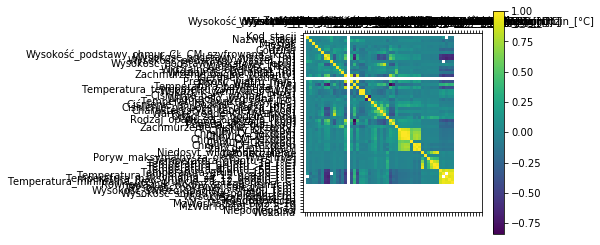

In [51]:
plt.matshow(df_warsaw.corr())
plt.xticks(range(len(df_warsaw.columns)), df_warsaw.columns)
plt.yticks(range(len(df_warsaw.columns)), df_warsaw.columns)
plt.colorbar()
plt.show()

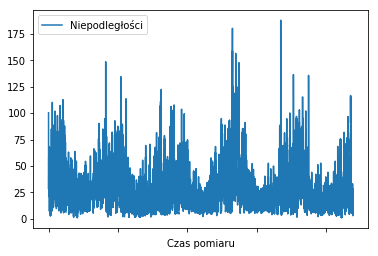

In [54]:
df_warsaw['Niepodległości'].plot()
plt.xlabel('Czas pomiaru')
#plt.ylabel(cols[0])
plt.legend()
plt.show()

In [ ]:
for index, data in enumerate(weather2018['Kod stacji']):
    weather2018['Czas pomiaru'][index] = datetime.datetime(year = weather2018['Rok'][index], month=weather2018['Miesiac'][index], day=weather2018['Dzien'][index], hour=weather2018['Godzina'][index])

In [60]:
df_warsaw.index=pd.to_datetime(df_warsaw.index)

In [63]:
df_warsaw['Niepodległości'] = df_warsaw['Niepodległości'].interpolate(method='linear', limit_direction='both')

E:\Programy\anaconda\Nowy folder\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


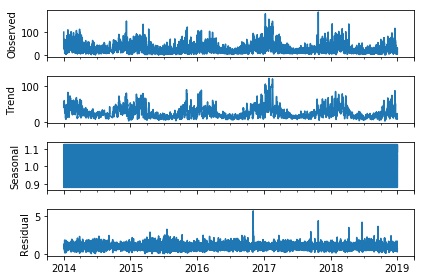

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_warsaw['Niepodległości'], model='multiplicative')
result.plot()
plt.show()

Jak zinterpretować taką wartość sezonal?

In [65]:
df_warsaw = df_warsaw.interpolate(method='linear', limit_direction='both')

In [66]:
df_warsaw.isna().sum()

Kod_stacji                                               0
Nazwa_stacji                                             5
Rok                                                      0
Miesiąc                                                  0
Dzień                                                    0
Godzina                                                  0
Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]           5
Wysokość_podstawy_niższej_[m]                            0
Wysokość_podstawy_wyższej_[m]                            0
Wysokość_podstawy_tekstowy_[opis]                        9
Widzialność_[kod]                                        0
Widzialność_operatora_[m]                                0
Widzialność_automat_[m]                                  0
Zachmurzenie_ogólne_[oktanty]                            0
Kierunek_wiatru_[°]                                      0
Prędkość_wiatru_[m/s]                                    0
Poryw_wiatru_[m/s]                                      

In [67]:
temp= df_warsaw

In [71]:
df_warsaw.drop(['Chmury_CL_[kod]', 'Chmury_CL_tekstem','Chmury_CM_[kod]','Chmury_CM_tekstem','Chmury_CH_[kod]','Chmury_CH_tekstem'],axis =1, inplace = True )

In [72]:

df_warsaw.isna().sum()

Kod_stacji                                              0
Nazwa_stacji                                            5
Rok                                                     0
Miesiąc                                                 0
Dzień                                                   0
Godzina                                                 0
Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]          5
Wysokość_podstawy_niższej_[m]                           0
Wysokość_podstawy_wyższej_[m]                           0
Wysokość_podstawy_tekstowy_[opis]                       9
Widzialność_[kod]                                       0
Widzialność_operatora_[m]                               0
Widzialność_automat_[m]                                 0
Zachmurzenie_ogólne_[oktanty]                           0
Kierunek_wiatru_[°]                                     0
Prędkość_wiatru_[m/s]                                   0
Poryw_wiatru_[m/s]                                      0
Temperatura_po

In [73]:
df_warsaw.drop(['Wskaźnik_wentylacji_[W/N]', 'Wysokość_podstawy_chmur_CL_CM_szyfrowana_[kod]','Nazwa_stacji','Wysokość_podstawy_tekstowy_[opis]'],axis =1, inplace = True )

In [74]:
df_warsaw.isna().sum()

Kod_stacji                                              0
Rok                                                     0
Miesiąc                                                 0
Dzień                                                   0
Godzina                                                 0
Wysokość_podstawy_niższej_[m]                           0
Wysokość_podstawy_wyższej_[m]                           0
Widzialność_[kod]                                       0
Widzialność_operatora_[m]                               0
Widzialność_automat_[m]                                 0
Zachmurzenie_ogólne_[oktanty]                           0
Kierunek_wiatru_[°]                                     0
Prędkość_wiatru_[m/s]                                   0
Poryw_wiatru_[m/s]                                      0
Temperatura_powietrza_[°C]                              0
Temperatura_termometru_zwilżonego_[°C]                  0
Ciśnienie_pary_wodnej_[hPa]                             0
Wilgotność_wzg

In [75]:
weather2018.describe()

Kod_stacji           Rok       Miesiąc         Dzień       Godzina  \
count      43819.0  43819.000000  43819.000000  43819.000000  43819.000000   
mean   352200375.0   2016.000000      6.524179     15.729501     11.501312   
std            0.0      1.413842      3.448264      8.798520      6.921570   
min    352200375.0   2014.000000      1.000000      1.000000      0.000000   
25%    352200375.0   2015.000000      4.000000      8.000000      6.000000   
50%    352200375.0   2016.000000      7.000000     16.000000     12.000000   
75%    352200375.0   2017.000000     10.000000     23.000000     18.000000   
max    352200375.0   2018.000000     12.000000     31.000000     23.000000   

       Status_pomiaru_HPOD  Wysokość_podstawy_niższej_[m]  \
count                  0.0                   43819.000000   
mean                   NaN                     533.111413   
std                    NaN                     618.613528   
min                    NaN                       0.000000   
25%                    NaN                       0.000000   
50%                    NaN                     250.000000   
75%                    NaN                    1000.000000   
max                    NaN                    2500.000000   

       Status_pomiaru_HPON  Wysokość_podstawy_wyższej_[m]  \
count              16060.0                   43819.000000   
mean                   8.0                     124.948424   
std                    0.0                     381.049178   
min                    8.0                       0.000000   
25%                    8.0                       0.000000   
50%                    8.0                       0.000000   
75%                    8.0                       0.000000   
max                    8.0                    6915.000000   

       Status_pomiaru_HPOW  Widzialność_[kod]  Status_pomiaru_WID  \
count              38695.0       43819.000000                 0.0   
mean                   8.0           7.301878                 NaN   
std                    0.0           1.004040                 NaN   
min                    8.0           1.000000                 NaN   
25%                    8.0           7.000000                 NaN   
50%                    8.0           8.000000                 NaN   
75%                    8.0           8.000000                 NaN   
max                    8.0           9.000000                 NaN   

       Widzialność_operatora_[m]  Status_pomiaru_WIDO  \
count               43819.000000                  1.0   
mean                19080.940893                  8.0   
std                  9990.424119                  NaN   
min                     0.000000                  8.0   
25%                 10000.000000                  8.0   
50%                 20000.000000                  8.0   
75%                 30000.000000                  8.0   
max                 50000.000000                  8.0   

       Widzialność_automat_[m]  Status_pomiaru_WIDA  \
count             43819.000000                  0.0   
mean                958.746366                  NaN   
std                4922.169839                  NaN   
min                   0.000000                  NaN   
25%                   0.000000                  NaN   
50%                   0.000000                  NaN   
75%                   0.000000                  NaN   
max               35000.000000                  NaN   

       Zachmurzenie_ogólne_[oktanty]  Status_pomiaru_NOG  Kierunek_wiatru_[°]  \
count                   43819.000000                 0.0         43819.000000   
mean                        5.177594                 NaN           179.077455   
std                         2.683717                 NaN            97.880668   
min                         0.000000                 NaN             0.000000   
25%                         3.000000                 NaN           104.000000   
50%                         6.000000                 NaN           170.000000   
75%   

In [76]:
df_warsaw.describe()

Kod_stacji           Rok       Miesiąc         Dzień       Godzina  \
count      43824.0  43824.000000  43824.000000  43824.000000  43824.000000   
mean   352200375.0   2016.000046      6.524302     15.729874     11.501620   
std            0.0      1.413834      3.448167      8.798321      6.921395   
min    352200375.0   2014.000000      1.000000      1.000000      0.000000   
25%    352200375.0   2015.000000      4.000000      8.000000      6.000000   
50%    352200375.0   2016.000000      7.000000     16.000000     12.000000   
75%    352200375.0   2017.000000     10.000000     23.000000     18.000000   
max    352200375.0   2018.000000     12.000000     31.000000     23.000000   

       Wysokość_podstawy_niższej_[m]  Wysokość_podstawy_wyższej_[m]  \
count                   43824.000000                   43824.000000   
mean                      533.101588                     124.934168   
std                       618.592718                     381.029777   
min                         0.000000                       0.000000   
25%                         0.000000                       0.000000   
50%                       260.000000                       0.000000   
75%                      1000.000000                       0.000000   
max                      2500.000000                    6915.000000   

       Widzialność_[kod]  Widzialność_operatora_[m]  Widzialność_automat_[m]  \
count       43824.000000               43824.000000             43824.000000   
mean            7.301810               19080.009059               959.050406   
std             1.004024                9990.354485              4922.580045   
min             1.000000                   0.000000                 0.000000   
25%             7.000000               10000.000000                 0.000000   
50%             8.000000               20000.000000                 0.000000   
75%             8.000000               30000.000000                 0.000000   
max             9.000000               50000.000000             35000.000000   

       Zachmurzenie_ogólne_[oktanty]  Kierunek_wiatru_[°]  \
count                   43824.000000         43824.000000   
mean                        5.177665           179.081109   
std                         2.683756            97.877295   
min                         0.000000             0.000000   
25%                         3.000000           104.000000   
50%                         6.000000           170.000000   
75%                         7.000000           268.000000   
max                         9.000000           360.000000   

       Prędkość_wiatru_[m/s]  Poryw_wiatru_[m/s]  Temperatura_powietrza_[°C]  \
count           43824.000000        43824.000000                43824.000000   
mean                3.400192            0.443068                    9.998210   
std                 2.002007            2.352424                    9.004835   
min                 0.000000            0.000000                  -18.600000   
25%                 2.000000            0.000000                    3.000000   
50%                 3.000000            0.000000                    9.600000   
75%                 5.000000            0.000000                   17.000000   
max                15.000000           25.000000                   36.200000   

       Temperatura_termometru_zwilżonego_[°C]  Ciśnienie_pary_wodnej_[hPa]  \
count                                 43824.0                 43824.000000   
mean                                      0.0                     9.795982   
std                                       0.0                     4.622977   
min                                       0.0                     1.200000   
25%                                       0.0                     6.200000   
50%                                       0.0                     8.900000   
75%                                       0.0                    13.000000   
max                                       0.0    

In [78]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
coint_johansen(df_warsaw,-1,1).eig

E:\Programy\anaconda\Nowy folder\lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:609: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  category=HypothesisTestWarning)


LinAlgError: Singular matrix

In [80]:
temp = df_warsaw[['Kierunek_wiatru_[°]','Prędkość_wiatru_[m/s]','Temperatura_powietrza_[°C]','Wilgotność_względna_[%]','Ciśnienie_na_pozimie_stacji_[hPa]','Ciśnienie_na_pozimie_morza_[hPa]','Niepodległości']]

In [81]:
temp.head()

Kierunek_wiatru_[°]  Prędkość_wiatru_[m/s]  \
2014-01-01 01:00:00                119.0                    4.0   
2014-01-01 02:00:00                128.0                    4.0   
2014-01-01 03:00:00                134.0                    3.0   
2014-01-01 04:00:00                129.0                    4.0   
2014-01-01 05:00:00                137.0                    4.0   

                     Temperatura_powietrza_[°C]  Wilgotność_względna_[%]  \
2014-01-01 01:00:00                         1.0                     93.0   
2014-01-01 02:00:00                         1.2                     92.0   
2014-01-01 03:00:00                         1.3                     92.0   
2014-01-01 04:00:00                         1.3                     92.0   
2014-01-01 05:00:00                         1.3                     91.0   

                     Ciśnienie_na_pozimie_stacji_[hPa]  \
2014-01-01 01:00:00                             1009.5   
2014-01-01 02:00:00                             1009.0   
2014-01-01 03:00:00                             1008.6   
2014-01-01 04:00:00                             1008.2   
2014-01-01 05:00:00                             1008.2   

                     Ciśnienie_na_pozimie_morza_[hPa]  Niepodległości  
2014-01-01 01:00:00                            1023.0      100.325798  
2014-01-01 02:00:00                            1022.5       69.412430  
2014-01-01 03:00:00                            1022.1       40.967861  
2014-01-01 04:00:00                            1021.7       37.308937  
2014-01-01 05:00:00                            1021.7       38.185955

In [82]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
coint_johansen(temp,-1,1).eig

array([9.14009014e-02, 6.82458391e-02, 5.40707850e-02, 4.39395480e-02,
       3.05353235e-02, 2.68354374e-03, 1.44015161e-07])

In [85]:
#creating the train and validation set
train = temp[:int(0.8*(len(temp)))]
valid = temp[int(0.8*(len(temp))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

E:\Programy\anaconda\Nowy folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [89]:
cols =['Kierunek_wiatru_[°]','Prędkość_wiatru_[m/s]','Temperatura_powietrza_[°C]','Wilgotność_względna_[%]','Ciśnienie_na_pozimie_stacji_[hPa]','Ciśnienie_na_pozimie_morza_[hPa]','Niepodległości']

In [91]:
pred

Kierunek_wiatru_[°] Prędkość_wiatru_[m/s] Temperatura_powietrza_[°C]  \
0                170.122               2.26524                    3.97133   
1                 176.39               2.48803                    4.04383   
2                181.244               2.67557                    4.11681   
3                185.016               2.83376                    4.18968   
4                187.957               2.96747                    4.26194   
5                190.258               3.08071                    4.33321   
6                192.064               3.17683                    4.40317   
7                193.484               3.25859                    4.47158   
8                194.605               3.32828                    4.53823   
9                 195.49               3.38783                    4.60299   
10                196.19               3.43882                    4.66576   
11               196.743                3.4826                    4.72647   
12               197.181               3.52028                    4.78507   
13               197.527               3.55279                    4.84156   
14               197.798               3.58091                    4.89593   
15                198.01               3.60531                     4.9482   
16               198.175               3.62654                     4.9984   
17                 198.3               3.64506                    5.04658   
18               198.394               3.66126                    5.09277   
19               198.462               3.67548                    5.13704   
20               198.508               3.68799                    5.17943   
21               198.538               3.69903                    5.22001   
22               198.552               3.70881                    5.25884   
23               198.555               3.71748                    5.29599   
24               198.548               3.72519                    5.33152   
25               198.532               3.73207                    5.36548   
26               198.509               3.73821                    5.39796   
27                198.48               3.74371                      5.429   
28               198.446               3.74865                    5.45866   
29               198.407               3.75308                    5.48702   
30               198.365               3.75706                    5.51412   
31               198.319               3.76064                    5.54002   
32               198.271               3.76387                    5.56478   
33                198.22               3.76677                    5.58845   
34               198.167               3.76938                    5.61107   
35               198.112               3.77172                    5.63271   
36               198.055               3.77382                    5.65341   
37               197.997                3.7757                     5.6732   
38               197.937               3.77738                    5.69214   
39               197.876               3.77887                    5.71027   
40               197.814               3.78019                    5.72763   
41               197.751               3.78135                    5.74425   
42               197.687               3.78236                    5.76017   
43               197.622               3.78323                    5.77543   
44               197.557               3.78397                    5.79006   
45               197.491               3.78458                    5.80409   
46               197.424               3.78509                    5.81755   
47               197.357               3.78548                    5.83048   
48               197.289               3.78578                    5.84289   
49                197.22               3.78598                    5.85482   
50               197.152               3.78609                     5.8663   
5

In [98]:
from math import *
from sklearn import *
from sklearn.metrics import mean_squared_error

In [99]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,7):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for Kierunek_wiatru_[°] is :  102.16164836451416
rmse value for Prędkość_wiatru_[m/s] is :  1.8835563057359694
rmse value for Temperatura_powietrza_[°C] is :  9.868097754798018
rmse value for Wilgotność_względna_[%] is :  18.630384935552428
rmse value for Ciśnienie_na_pozimie_stacji_[hPa] is :  8.08005613938973
rmse value for Ciśnienie_na_pozimie_morza_[hPa] is :  8.270111966410417
rmse value for Niepodległości is :  17.37837737079767


In [102]:
#make final predictions
model = VAR(endog=temp)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=100)
print(yhat)

[[ 219.45590554    2.17495055    2.26028018   82.87356458 1013.440051
  1026.84938319   28.97821096]
 [ 204.68963428    2.3272888     2.32477312   82.71702788 1013.47182323
  1026.88751416   29.83799229]
 [ 193.53916416    2.4590503     2.39261396   82.53453026 1013.49709679
  1026.91686103   30.60255047]
 [ 185.12239203    2.57233735    2.46305128   82.33018022 1013.51718281
  1026.93926436   31.27962062]
 [ 178.77026602    2.66921482    2.53543702   82.10789357 1013.5330454
  1026.95609599   31.87719616]
 [ 173.97579113    2.75164469    2.60921598   81.87129821 1013.54539293
  1026.96837855   32.40314955]
 [ 170.35515796    2.82144796    2.68391551   81.62368457 1013.55474615
  1026.97687525   32.86499288]
 [ 167.61812707    2.88028549    2.75913567   81.36798716 1013.56148887
  1026.98215711   33.26973702]
 [ 165.54547729    2.92965186    2.8345401    81.10678672 1013.56590555
  1026.9846533    33.62381958]
 [ 163.97184252    2.97087774    2.90984768   80.84232556 1013.56820905
  10

E:\Programy\anaconda\Nowy folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [105]:
# Forecast

df_forecast = pd.DataFrame(yhat, index=temp.index[-100:], columns=temp.columns + '_2d')
df_forecast

Kierunek_wiatru_[°]_2d  Prędkość_wiatru_[m/s]_2d  \
2018-12-27 21:00:00              219.455906                  2.174951   
2018-12-27 22:00:00              204.689634                  2.327289   
2018-12-27 23:00:00              193.539164                  2.459050   
2018-12-28 00:00:00              185.122392                  2.572337   
2018-12-28 01:00:00              178.770266                  2.669215   
2018-12-28 02:00:00              173.975791                  2.751645   
2018-12-28 03:00:00              170.355158                  2.821448   
2018-12-28 04:00:00              167.618127                  2.880285   
2018-12-28 05:00:00              165.545477                  2.929652   
2018-12-28 06:00:00              163.971843                  2.970878   
2018-12-28 07:00:00              162.772658                  3.005138   
2018-12-28 08:00:00              161.854237                  3.033460   
2018-12-28 09:00:00              161.146238                  3.056743   
2018-12-28 10:00:00              160.595942                  3.075761   
2018-12-28 11:00:00              160.163916                  3.091186   
2018-12-28 12:00:00              159.820730                  3.103593   
2018-12-28 13:00:00              159.544470                  3.113474   
2018-12-28 14:00:00              159.318857                  3.121249   
2018-12-28 15:00:00              159.131833                  3.127278   
2018-12-28 16:00:00              158.974487                  3.131864   
2018-12-28 17:00:00              158.840251                  3.135262   
2018-12-28 18:00:00              158.724299                  3.137691   
2018-12-28 19:00:00              158.623092                  3.139333   
2018-12-28 20:00:00              158.534037                  3.140340   
2018-12-28 21:00:00              158.455237                  3.140843   
2018-12-28 22:00:00              158.385302                  3.140947   
2018-12-28 23:00:00              158.323210                  3.140742   
2018-12-29 00:00:00              158.268203                  3.140303   
2018-12-29 01:00:00              158.219712                  3.139691   
2018-12-29 02:00:00              158.177304                  3.138956   
2018-12-29 03:00:00              158.140638                  3.138140   
2018-12-29 04:00:00              158.109438                  3.137276   
2018-12-29 05:00:00              158.083473                  3.136393   
2018-12-29 06:00:00              158.062541                  3.135512   
2018-12-29 07:00:00              158.046460                  3.134651   
2018-12-29 08:00:00              158.035060                  3.133823   
2018-12-29 09:00:00              158.028180                  3.133040   
2018-12-29 10:00:00              158.025663                  3.132310   
2018-12-29 11:00:00              158.027356                  3.131639   
2018-12-29 12:00:00              158.033107                  3.131031   
2018-12-29 13:00:00              158.042767                  3.130489   
2018-12-29 14:00:00              158.056188                  3.130015   
2018-12-29 15:00:00              158.073223                  3.129610   
2018-12-29 16:00:00              158.093727                  3.129274   
2018-12-29 17:00:00              158.117557                  3.129006   
2018-12-29 18:00:00              158.144574                  3.128805   
2018-12-29 19:00:00              158.174639                  3.128670   
2018-12-29 20:00:00              158.207618                  3.128599   
2018-12-29 21:00:00              158.243379                  3.128590   
2018-12-29 22:00:00              158.281795                  3.128640   
2018-12-29 23:00:00              158.322741                  3.128749   
2018-12-30 00:00:00              158.366096                  3.128913   
2018-12-30 01:00:00              158.411742                  3.129129   
2018-12-30 02:00:00              158.459567                  3.129397   
2018-1

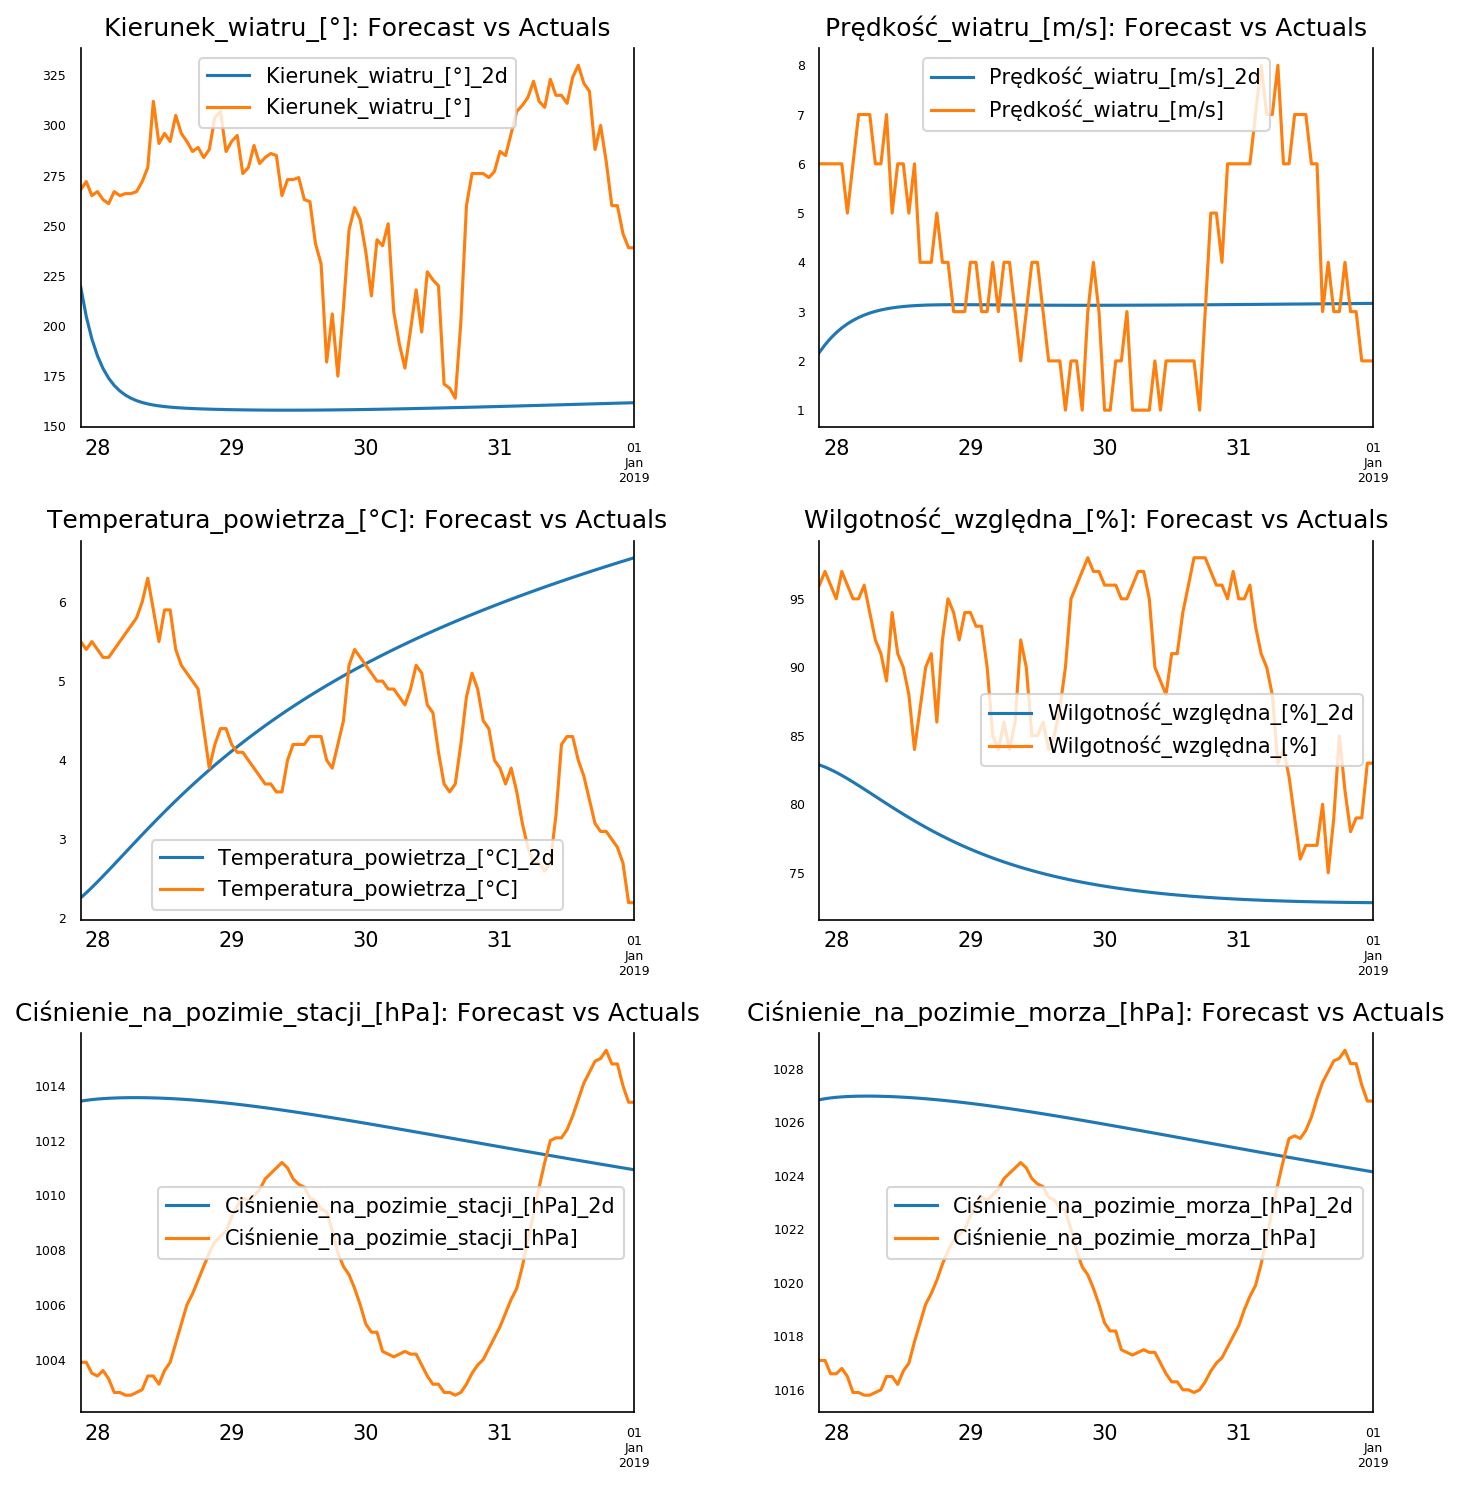

In [114]:
fig, axes = plt.subplots(nrows=int(len(temp.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(temp.columns, axes.flatten())):
    df_forecast[col+'_2d'][-100:].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    valid[col][-100:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();